In [1]:
import os
from tqdm import tqdm
import json
import pickle
import logging
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pyarrow.feather as feather

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, accuracy_score,
    roc_curve, auc, log_loss
)

from catboost import CatBoostClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import optuna

from sklearn.preprocessing import label_binarize
from sklearn.metrics import ndcg_score
from catboost import CatBoostRanker, Pool



## Обработка датасета

In [2]:
df_features_sample_load = pd.read_feather("data_for_students_features_sample_400cols.feather")
df_features_sample_load = df_features_sample_load.rename(columns = {'smt_decision_makerid_hash':'smt_decision_makerid'})


In [3]:
df_campaigns_load = pd.read_feather("for_students/campaigns.feather")

df_campaigns_load['report_date'] = df_campaigns_load['delivery_date'].apply(
    lambda x: x - pd.to_timedelta((x.weekday() + 1) % 7, unit='D')
)

In [4]:
df_targets_load = pd.read_feather("for_students/targets.feather")
df_targets_load['report_date'] = df_targets_load['report_date'].apply(
    lambda x: x - pd.to_timedelta((x.weekday() + 1) % 7, unit='D')
)
df_targets_load['report_date'] = df_targets_load['report_date'].dt.date

# берём строки из duf только до 15.12, потому что таргет до конца 24
#df_targets_load = df_targets_load[df_targets_load.report_date<='2024-12-15']

# убираем повторяющиеся фичи юзера, которые получились в датасете в результате нескольких рассылок

df_targets_load.drop_duplicates(subset=['smt_decision_makerid', 'report_date'], inplace=True)

In [5]:
print("Доля пересеченных пользователей: ", \
      round(1 - len(set(df_campaigns_load.smt_decision_makerid) - set(df_features_sample_load.smt_decision_makerid)) \
          / len(set(df_campaigns_load.smt_decision_makerid)),3))

Доля пересеченных пользователей:  0.999


In [6]:
# df_validate = pd.read_excel("test_dataset_exclude_ids.xlsx")
# df_validate['delivery_date'] = pd.to_datetime(df_validate['delivery_date'])

# df_campaigns_load['delivery_date']       = pd.to_datetime(df_campaigns_load['delivery_date'])
# df_features_sample_load['delivery_date'] = pd.to_datetime(df_features_sample_load['delivery_date'])

# validate_keys = (
#     df_validate
#     [['smt_decision_makerid','delivery_date']]
#     .drop_duplicates()
# )

# def split_general_and_validation(df, name):
#     merged = df.merge(
#         validate_keys,
#         on=['smt_decision_makerid','delivery_date'],
#         how='left',
#         indicator=True
#     )
#     df_val = merged[merged['_merge']=='both'].drop(columns=['_merge'])
#     df_gen = merged[merged['_merge']=='left_only'].drop(columns=['_merge'])
    
#     total = len(df)
#     val_n  = len(df_val)
#     gen_n  = len(df_gen)
#     print(
#         f"{name}: всего {total}, "
#         f"валидационным = {val_n} ({val_n/total:.2%}), "
#         f"обучающим = {gen_n} ({gen_n/total:.2%})"
#     )
#     return df_gen.reset_index(drop=True), df_val.reset_index(drop=True)

# df_campaigns,       df_campaigns_val       = split_general_and_validation(df_campaigns_load,       "df_campaigns")
# df_features_sample, df_features_sample_val = split_general_and_validation(df_features_sample_load, "df_features_sample")


In [7]:
x_test_set_for_metrics_check =  pd.read_excel('x_test_set_for_metrics_check.xlsx')
x_val_set_for_params_tuning =  pd.read_excel('x_val_set_for_params_tuning.xlsx')

x_test_set_for_metrics_check['report_date'] = pd.to_datetime(x_test_set_for_metrics_check['report_date'])
x_val_set_for_params_tuning['report_date'] = pd.to_datetime(x_val_set_for_params_tuning['report_date'])
df_features_sample_load['report_date'] = pd.to_datetime(df_features_sample_load['report_date'])

# keys_metrics = set(zip(
#     x_test_set_for_metrics_check['smt_decision_makerid'],
#     x_test_set_for_metrics_check['report_date']
# ))
# keys_params = set(zip(
#     x_val_set_for_params_tuning['smt_decision_makerid'],
#     x_val_set_for_params_tuning['report_date']
# ))

# pairs = list(zip(
#     df_features_sample_load['smt_decision_makerid'],
#     df_features_sample_load['report_date']
# ))
# mask_metrics = [p in keys_metrics for p in pairs]
# mask_params  = [p in keys_params  for p in pairs]

# df_features_sample_for_metrics_check = df_features_sample_load[mask_metrics].reset_index(drop=True)
# df_features_sample_for_params_tuning  = df_features_sample_load[mask_params].reset_index(drop=True)
# df_features_sample  = df_features_sample_load[ [not (m or p) for m, p in zip(mask_metrics, mask_params)] ] \
#                     .reset_index(drop=True)

# print(f"Пересечение с metrics_check: {len(df_features_sample_for_metrics_check)} строк ({len(df_features_sample_for_metrics_check)/len(df_features_sample_load):.2%})")
# print(f"Пересечение с params_tuning: {len(df_features_sample_for_params_tuning)} строк ({len(df_features_sample_for_params_tuning)/len(df_features_sample_load):.2%})")
# print(f"Осталось для обучения     : {len(df_features_sample)} строк ({len(df_features_sample)/len(df_features_sample_load):.2%})")


df_features_sample = df_features_sample_load[df_features_sample_load.report_date < '2024-12-08']
df_features_sample_for_params_tuning = df_features_sample_load.merge(x_val_set_for_params_tuning, on = ['smt_decision_makerid', 'report_date'])

df_features_sample_for_metrics_check = df_features_sample_load.merge(x_test_set_for_metrics_check, on = ['smt_decision_makerid', 'report_date'])

print(f"Пересечение с metrics_check: {len(df_features_sample_for_metrics_check)} строк ({len(df_features_sample_for_metrics_check)/len(df_features_sample_load):.2%})")
print(f"Пересечение с params_tuning: {len(df_features_sample_for_params_tuning)} строк ({len(df_features_sample_for_params_tuning)/len(df_features_sample_load):.2%})")
print(f"Осталось для обучения     : {len(df_features_sample)} строк ({len(df_features_sample)/len(df_features_sample_load):.2%})")


Пересечение с metrics_check: 176233 строк (12.67%)
Пересечение с params_tuning: 135293 строк (9.73%)
Осталось для обучения     : 900578 строк (64.75%)


In [8]:
set(df_features_sample[df_features_sample.report_date > '2024-12-08'].smt_decision_makerid) & \
    set(df_features_sample_for_metrics_check.smt_decision_makerid)

set()

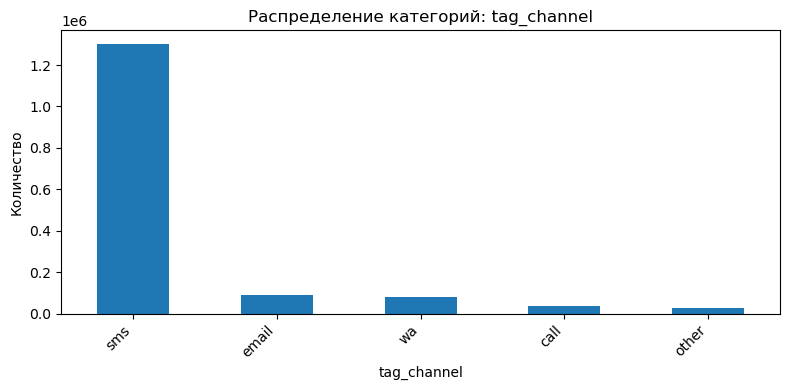


Редкие категории в «tag_channel» (доля < 5.00%):
  • 'call': 34097 (2.23%)
  • 'other': 27418 (1.79%)


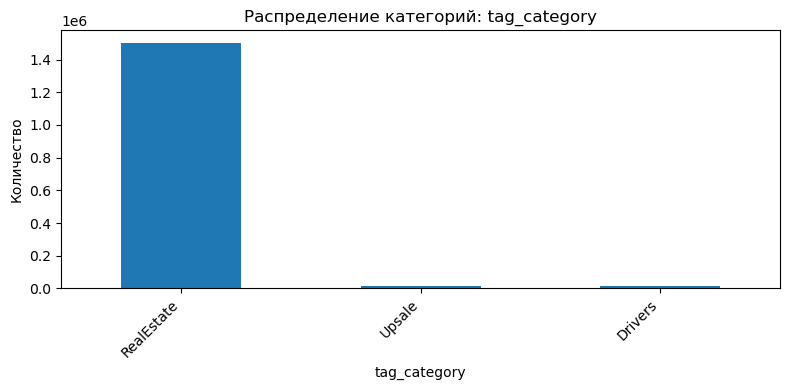


Редкие категории в «tag_category» (доля < 5.00%):
  • 'Upsale': 15000 (0.98%)
  • 'Drivers': 12000 (0.78%)


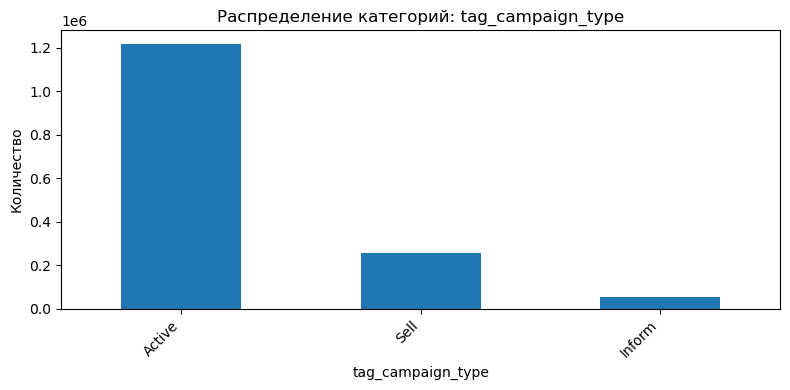


Редкие категории в «tag_campaign_type» (доля < 5.00%):
  • 'Inform': 52875 (3.46%)


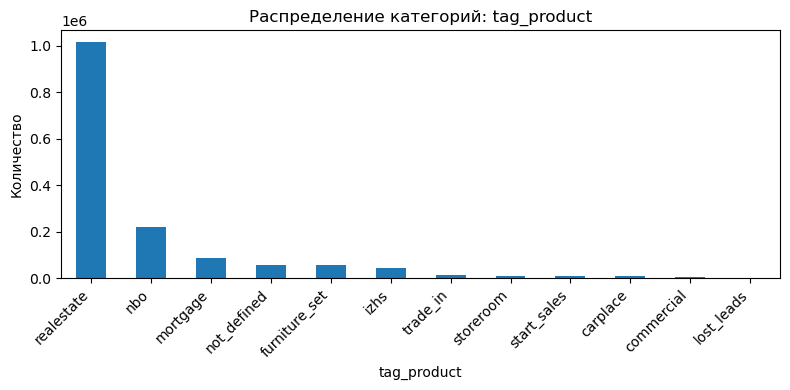


Редкие категории в «tag_product» (доля < 5.00%):
  • 'not_defined': 57520 (3.76%)
  • 'furniture_set': 56793 (3.71%)
  • 'izhs': 42928 (2.81%)
  • 'trade_in': 12000 (0.78%)
  • 'storeroom': 10999 (0.72%)
  • 'start_sales': 10000 (0.65%)
  • 'carplace': 7500 (0.49%)
  • 'commercial': 5081 (0.33%)
  • 'lost_leads': 2820 (0.18%)


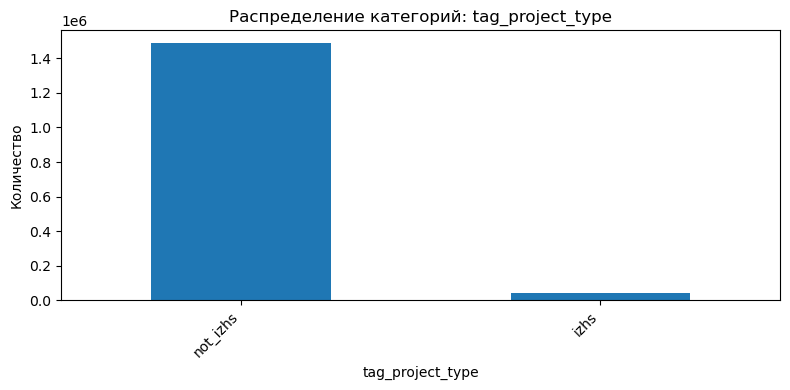


Редкие категории в «tag_project_type» (доля < 5.00%):
  • 'izhs': 42928 (2.81%)


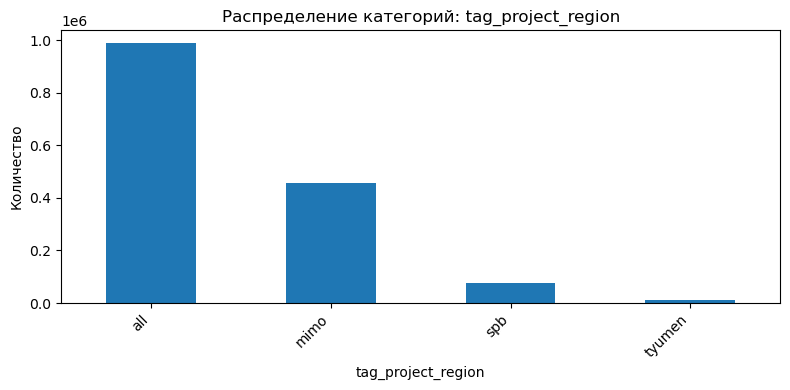


Редкие категории в «tag_project_region» (доля < 5.00%):
  • 'spb': 75965 (4.96%)
  • 'tyumen': 10435 (0.68%)


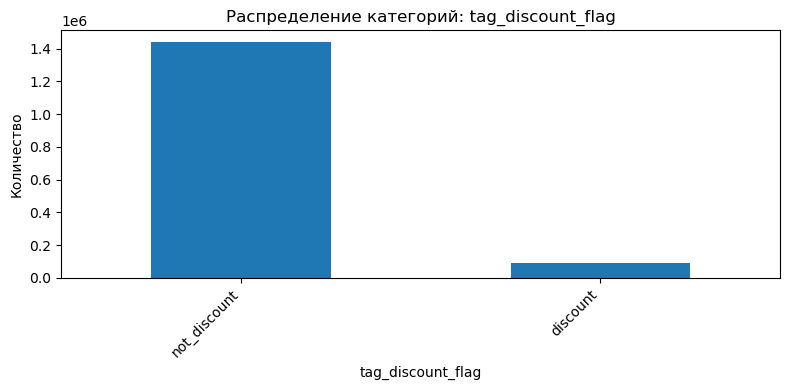


В «tag_discount_flag» нет категорий с долей < 5.00%.


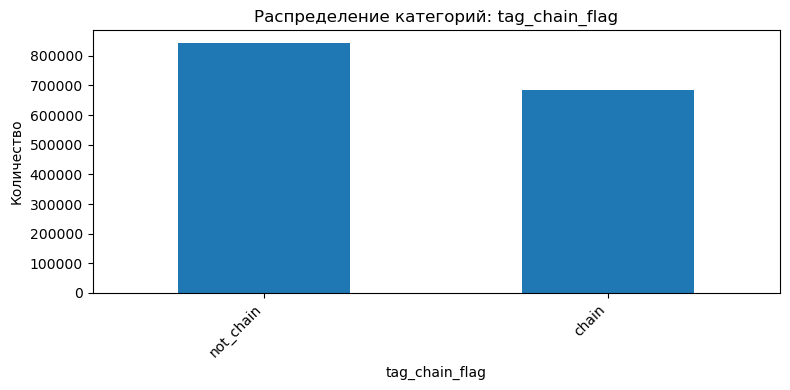


В «tag_chain_flag» нет категорий с долей < 5.00%.


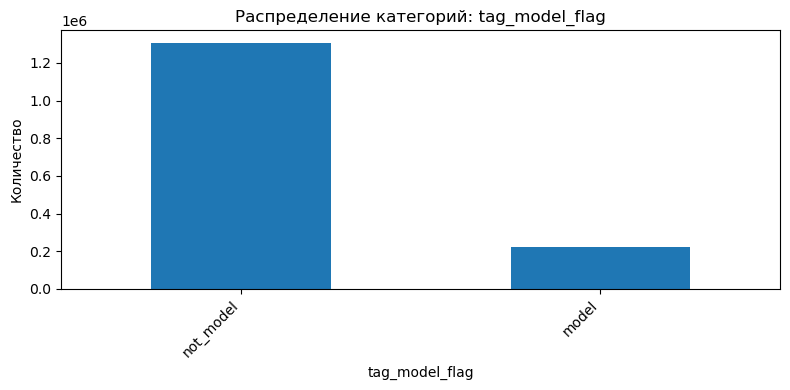


В «tag_model_flag» нет категорий с долей < 5.00%.


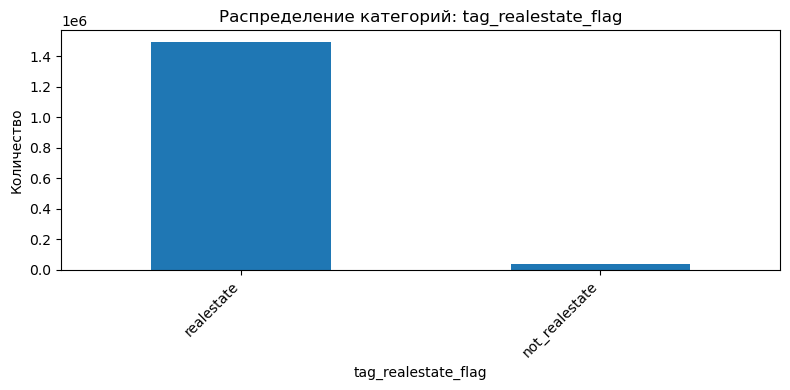


Редкие категории в «tag_realestate_flag» (доля < 5.00%):
  • 'not_realestate': 35580 (2.33%)


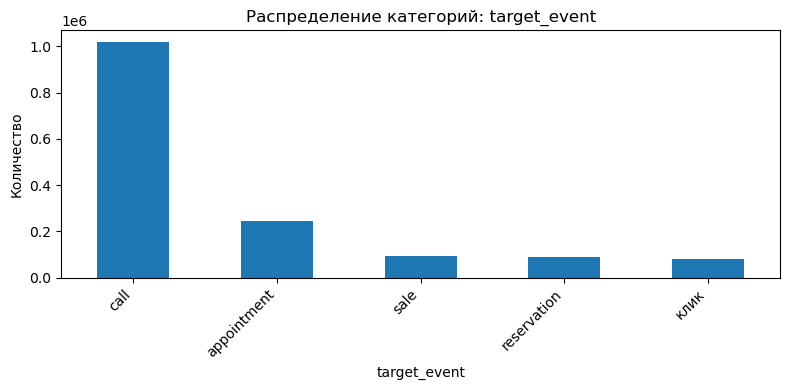


В «target_event» нет категорий с долей < 5.00%.

Сводка всех редких категорий по доле:


,column,category,count,ratio
0,tag_channel,call,34097,0.022282
1,tag_channel,other,27418,0.017917
2,tag_category,Upsale,15000,0.009802
3,tag_category,Drivers,12000,0.007842
4,tag_campaign_type,Inform,52875,0.034552
5,tag_product,not_defined,57520,0.037588
6,tag_product,furniture_set,56793,0.037113
7,tag_product,izhs,42928,0.028052
8,tag_product,trade_in,12000,0.007842
9,tag_product,storeroom,10999,0.007188


In [9]:
def plot_tag_distributions_and_find_rare_by_ratio(df: pd.DataFrame,
                                                  tag_prefix: str = "tag",
                                                  rare_threshold: float = 0.01):
    """
    Для каждого столбца df, название которого начинается с tag_prefix:
      1) Рисует bar-plot распределения абсолютных частот его категорий.
      2) Считает долю каждой категории и выводит те, у которых доля < rare_threshold.
    
    Параметры:
      df              — исходный DataFrame (здесь df_campaigns);
      tag_prefix      — префикс для отбора колонок;
      rare_threshold  — порог по доле для «редких» категорий (float в (0,1)).
    """
    total = len(df)
    rare_list = []
    tag_cols = [c for c in df.columns if c.startswith(tag_prefix)]
    tag_cols = tag_cols + ['target_event']

    for col in tag_cols:
        counts = df[col].value_counts(dropna=False)
        ratios = counts / total

        # 1) график абсолютных частот
        plt.figure(figsize=(8, 4))
        counts.plot(kind='bar')
        plt.title(f"Распределение категорий: {col}")
        plt.xlabel(col)
        plt.ylabel("Количество")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        # 2) редкие по доле < rare_threshold
        rare = ratios[ratios < rare_threshold]
        if not rare.empty:
            print(f"\nРедкие категории в «{col}» (доля < {rare_threshold:.2%}):")
            for category, ratio in rare.items():
                cnt = counts.loc[category]
                print(f"  • {category!r}: {cnt} ({ratio:.2%})")
                rare_list.append((col, category, cnt, ratio))
        else:
            print(f"\nВ «{col}» нет категорий с долей < {rare_threshold:.2%}.")

    if rare_list:
        rare_df = pd.DataFrame(
            rare_list,
            columns=["column", "category", "count", "ratio"]
        )
        print("\nСводка всех редких категорий по доле:")
        display(rare_df)
        return rare_df
    else:
        print("\nНет ни одной «редкой» категории во всех tag-столбцах по заданной доле.")
        return pd.DataFrame(columns=["column", "category", "count", "ratio"])


rare_categories_df = plot_tag_distributions_and_find_rare_by_ratio(
    df_campaigns_load,
    tag_prefix="tag",
    rare_threshold=0.05
)


In [10]:
#признаки коммуникации для прогноза
target_tags = [    
    'tag_channel',
    #'tag_category',
    'tag_campaign_type',
    #'tag_product',
    #'tag_project_type',
    'tag_project_region',
    'tag_discount_flag',
    'tag_chain_flag',
    #'tag_model_flag',
    'target_event',
    #'tag_realestate_flag'
]


In [11]:
def filter_high_correlation(
    df: pd.DataFrame,
    cols: pd.Index,
    threshold: float = 0.95
) -> pd.Index:
    """
    Убирает из `cols` те признаки, у которых pairwise-corr > threshold.
    Рисует:
      1) heatmap корреляций для всех признаков в cols,
      2) heatmap корреляций только для исключённых (to_drop).
    Выводит список удалённых колонок.
    Возвращает отфильтрованный Index.
    """
    corr = df[cols].corr().abs()

    # Общий heatmap
    mask_all = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        mask=mask_all,
        cmap="vlag",
        linewidths=0.5,
        cbar_kws={"shrink": .5}
    )
    plt.title("Heatmap корреляций всех признаков")
    plt.show()

    # Фильтрация
    upper = corr.where(mask_all)
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
    keep = cols.difference(to_drop)

    #Heatmap для дропнутых (если есть)
    if to_drop:
        corr_drop = corr.loc[to_drop, to_drop]
        mask_drop = np.triu(np.ones_like(corr_drop, dtype=bool))
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr_drop,
            mask=mask_drop,
            cmap="vlag",
            linewidths=0.5,
            cbar_kws={"shrink": .5}
        )
        plt.title("Heatmap корреляций исключённых признаков")
        plt.show()

    #Лог и печать
    print(f"\nУбраны {len(to_drop)} фичи (corr > {threshold}):")
    for col in to_drop:
        print("  -", col)

    return keep


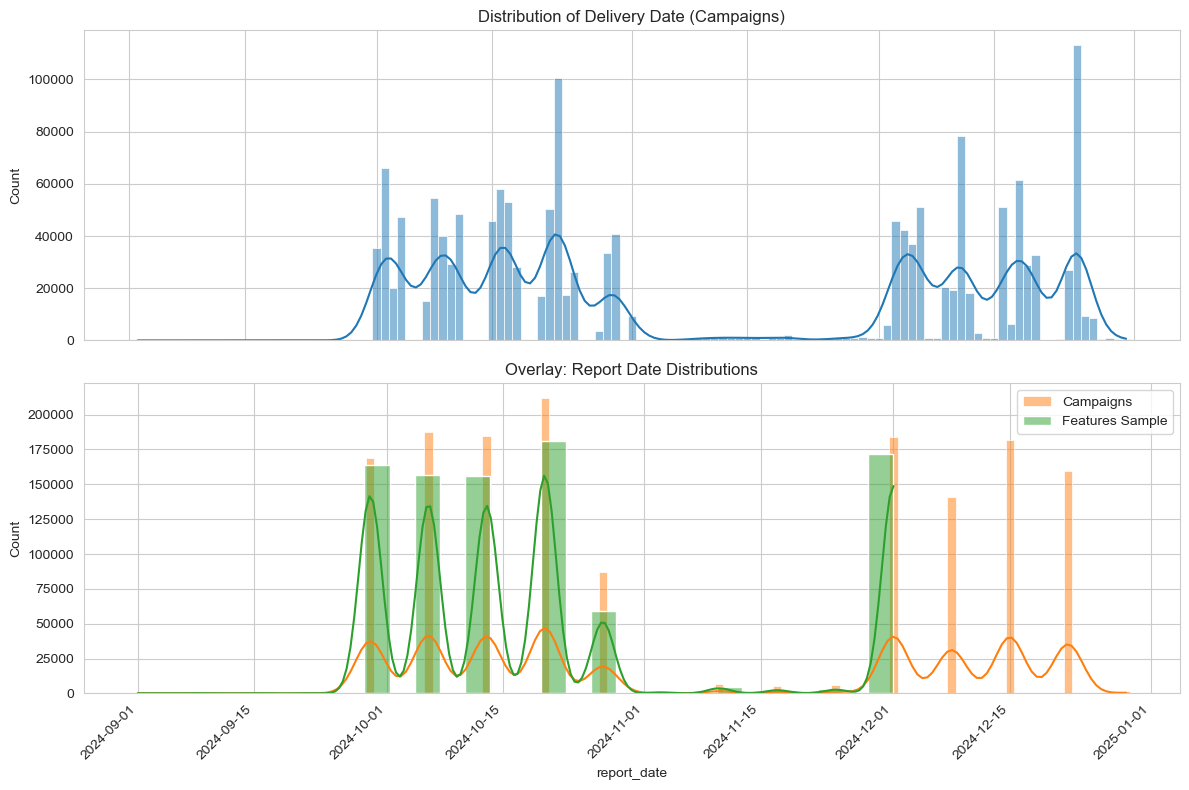

In [12]:

sns.set_style('whitegrid')

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

# 1) Гистограмма delivery_date (df_campaigns_load)
sns.histplot(
    data=df_campaigns_load,
    x='delivery_date',
    bins=30,
    kde=True,
    ax=axes[0],
    color='C0'
)
axes[0].set_title('Distribution of Delivery Date (Campaigns)')
axes[0].set_ylabel('Count')
axes[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# 2) Наложенные гистограммы report_date
sns.histplot(
    data=df_campaigns_load,
    x='report_date',
    bins=30,
    kde=True,
    ax=axes[1],
    label='Campaigns',
    color='C1',
    alpha=0.5
)
sns.histplot(
    data=df_features_sample,
    x='report_date',
    bins=30,
    kde=True,
    ax=axes[1],
    label='Features Sample',
    color='C2',
    alpha=0.5
)
axes[1].set_title('Overlay: Report Date Distributions')
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Общая настройка дат
fig.autofmt_xdate(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
# мерж даатфреймов кампаний и юзеров
df_campaigns_load['report_date'] = pd.to_datetime(df_campaigns_load['report_date'], errors='coerce')
df_features_sample['report_date'] = pd.to_datetime(df_features_sample['report_date'], errors='coerce')

df_merged = pd.merge(df_campaigns_load, df_features_sample, on=["smt_decision_makerid", "report_date"], how="inner")
df_merged_test = pd.merge(df_campaigns_load, df_features_sample_for_params_tuning, on=["smt_decision_makerid", "report_date"], how="inner")
df_merged_val = pd.merge(df_campaigns_load, df_features_sample_for_metrics_check, on=["smt_decision_makerid", "report_date"], how="inner")

print("Merged dataset shape:", df_merged.shape)

# убираем скоррелированные фичи
numeric_cols = df_features_sample.select_dtypes(include=['float32']).columns
#numeric_cols = filter_high_correlation(df_merged, numeric_cols, threshold=0.95)
numeric_cols_filtered = numeric_cols

df_merged[target_tags] = df_merged[target_tags].fillna('no_tag')
df_merged_test[target_tags] = df_merged_test[target_tags].fillna('no_tag')


Merged dataset shape: (1087341, 379)


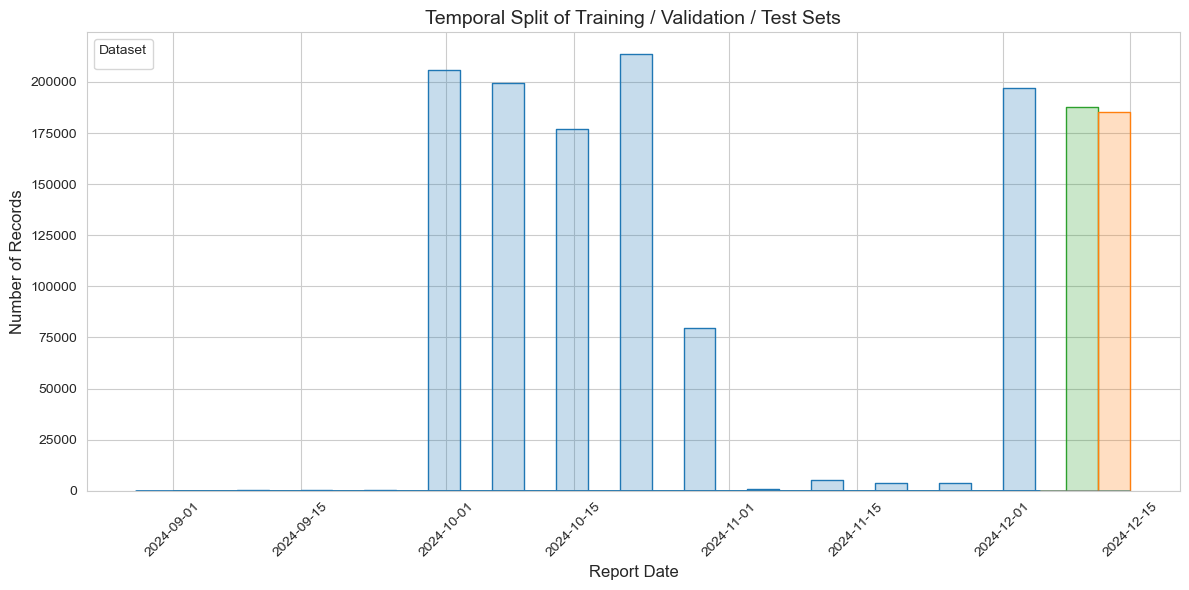

In [14]:
sns.set_style('whitegrid')

# Добавляем колонку с меткой набора (фикс кавычек!)
df_train = df_merged.assign(dataset='Train (training)')
df_val   = df_merged_val.assign(dataset='Val (tuning / metrics)')
df_test  = df_merged_test.assign(dataset='Test (final evaluation)')

# Объединяем
df_combined = pd.concat([df_train, df_val, df_test], ignore_index=True)

plt.figure(figsize=(12, 6))

# Контурные гистограммы трёх выборок
sns.histplot(
    data=df_combined,
    x='report_date',
    hue='dataset',
    bins=30,
    element='step',
    stat='count',
    common_norm=False,
    palette=['C0', 'C1', 'C2']
)

# Плавные KDE-кривые
sns.kdeplot(
    data=df_combined,
    x='report_date',
    hue='dataset',
    common_norm=False,
    lw=2,
    palette=['C0', 'C1', 'C2']
)

# Оформление
plt.title('Temporal Split of Training / Validation / Test Sets', fontsize=14)
plt.xlabel('Report Date', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()


In [15]:
df_merged

,smt_decision_makerid,delivery_date_x,hash,campaign_name,segment_name,ab_group,tag_channel,tag_category,tag_campaign_type,tag_product,...,wishlists__g_client__secondary_nbrs_houses__price__radius_1_5km__avg__1M__avg__ALL_TIME,wishlists__g_client__crm_objects__smt_sale_price_rooms_0__avg__avg__ALL_TIME,wishlists__g_client__crm_objects__smt_sale_price_rooms_2__avg__avg__180D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__180D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__365D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__ALL_TIME,wishlists__g_client__wl_createdon__min__ALL_TIME,wishlists__g_client__wl_createdon__max__180D,wishlists__g_client__wl_createdon__max__ALL_TIME,delivery_date_y
0,cd71ba6d85a7e0c379e54892a6b931de,2024-10-02,4df189d22038fd188fef0ec54a9cba6c,[batch] [241002] [SMS] Первичная недвижимость ...,DSML-1814,target,sms,RealEstate,Active,realestate,...,10597654.0,2190987.75,3630772.5,0.845514,0.845514,0.845514,12.0,12.0,12.0,2024-10-02
1,340dd300a3093e8120264d701ca9f73c,2024-12-03,ef401fc6177a7592861c437cb6ce728b,[batch] [241203] [SMS] [МСК] Первичная недвижи...,CMPG-3843,control,sms,RealEstate,Active,realestate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-03
2,340dd300a3093e8120264d701ca9f73c,2024-10-03,ef401fc6177a7592861c437cb6ce728b,[batch] [241003] [SMS] Первичная недвижимость ...,DSML-1844,control,sms,RealEstate,Active,realestate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-03
3,340dd300a3093e8120264d701ca9f73c,2024-10-16,ef401fc6177a7592861c437cb6ce728b,[batch] [241009] [SMS call] Первичная недвижим...,DSML-790,target,sms,RealEstate,Sell,nbo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-16
4,340dd300a3093e8120264d701ca9f73c,2024-10-16,ef401fc6177a7592861c437cb6ce728b,[batch] [241009] [SMS call] Первичная недвижим...,DSML-790,target,sms,RealEstate,Sell,nbo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087336,e0a23b3d91acc62f324905c962d6c092,2024-10-16,f0aa55c4ab5fe4afea4630e5e44f8753,[batch] [241015] [EMAIL] Первичная недвижимост...,CMPG-3038,target,email,RealEstate,Active,realestate,...,12848333.0,3623351.50,NaN,NaN,0.775097,0.775097,230.0,NaN,230.0,2024-10-16
1087337,e0a23b3d91acc62f324905c962d6c092,2024-10-23,f0aa55c4ab5fe4afea4630e5e44f8753,[batch] [241010] [SMS] Квартиры с кухней и меб...,CMPG-3553,target,email,RealEstate,Active,furniture_set,...,12848333.0,3627320.50,NaN,NaN,0.775097,0.775097,237.0,NaN,237.0,2024-10-23
1087338,e1b732abf935aa7b7724c16925669d94,2024-10-23,5228090e2a6e672cdee441a091d34252,[batch] [241010] [SMS] Квартиры с кухней и меб...,CMPG-3553,target,email,RealEstate,Active,furniture_set,...,10503004.0,5868729.50,NaN,NaN,0.780264,0.780264,192.0,NaN,219.0,2024-10-23
1087339,b042048f7ca3cf26985e69cf70f18e11,2024-10-16,4bad540d95d6a104854ae61cf46ee55d,[batch] [241015] [EMAIL] Первичная недвижимост...,CMPG-3038,target,email,RealEstate,Active,realestate,...,7478404.0,5256619.50,NaN,NaN,NaN,0.852327,935.0,NaN,935.0,2024-10-16


## Пробуем подходы к прогнозу тегов

In [57]:
from catboost import CatBoostRanker, Pool

# Папка для сохранения ранжировщика
RANK_MODEL_DIR = "saved_models_rank"
os.makedirs(RANK_MODEL_DIR, exist_ok=True)

# Признаки, таргет и группы
features   = numeric_cols_filtered
group_col  = "smt_decision_makerid"
target_col = "tag_channel"

# 1) Train & Test из заранее сформированных наборов
X_train = df_merged[features]
y_train = df_merged[target_col]
g_train = df_merged[group_col]

X_test  = df_merged_test[features]
y_test  = df_merged_test[target_col]
g_test  = df_merged_test[group_col]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# 2) Преобразуем метки в численные relevance
unique_classes = list(y_train.unique())
rel_map        = {cls: idx for idx, cls in enumerate(unique_classes)}
inv_map        = {v: k for k, v in rel_map.items()}

y_train_rel = y_train.map(rel_map)
y_test_rel  = y_test.map(rel_map)

# 3) Сортируем по group_id (обязательно для Pool)
order_tr = np.argsort(g_train.values)
X_tr = X_train.iloc[order_tr].reset_index(drop=True)
y_tr = y_train_rel.iloc[order_tr].reset_index(drop=True)
g_tr = g_train.iloc[order_tr].reset_index(drop=True)

order_te = np.argsort(g_test.values)
X_te = X_test.iloc[order_te].reset_index(drop=True)
y_te = y_test_rel.iloc[order_te].reset_index(drop=True)
g_te = g_test.iloc[order_te].reset_index(drop=True)

# 4) Создаём Pool'ы
train_pool = Pool(data=X_tr, label=y_tr, group_id=g_tr)
eval_pool  = Pool(data=X_te, label=y_te, group_id=g_te)

# 5) Обучаем CatBoostRanker
ranker = CatBoostRanker(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function="YetiRank",
    eval_metric="NDCG:top=1",
    #use_best_model=True,
    early_stopping_rounds=100,
    random_seed=42,
    verbose=500
)
ranker.fit(train_pool)

# 6) Сохраняем модель
ranker.save_model(os.path.join(RANK_MODEL_DIR, "rank_tag_channel.cbm"))

# 7) Предсказываем ранжировочные скор-ы
y_score = ranker.predict(X_te)  # одномерный массив длины n_samples

# 8) Строим DataFrame для подсчёта Top-1 групповой accuracy
df_scores = pd.DataFrame({
    "group": g_te,
    "y_rel": y_te,
    "score": y_score
})

# Для каждой группы находим индекс строки с max score
idx_top1 = df_scores.groupby("group")["score"].idxmax()
pred_df  = df_scores.loc[idx_top1].reset_index(drop=True)

# Истинная релевантность группы — mode(y_rel) этой группы
true_rel = (
    df_scores
    .groupby("group")["y_rel"]
    .agg(lambda x: x.mode().iat[0])
    .reset_index(name="y_rel_true")
)

# Сливаем предсказания и истинные метки по 'group'
cmp = pred_df.merge(true_rel, on="group")

# 9) Считаем accuracy на уровне групп
acc_ranker = accuracy_score(cmp["y_rel_true"], cmp["y_rel"])
print(f"Group-level Accuracy from ranker: {acc_ranker:.4f}")


Train size: 1087341, Test size: 187839
0:	total: 367ms	remaining: 6m 6s
500:	total: 3m 24s	remaining: 3m 24s
999:	total: 6m 46s	remaining: 0us
Group-level Accuracy from ranker: 0.9857


In [74]:
def plot_multiclass_roc(y_true, y_score, classes, target_name):
    """
    Строит One-vs-Rest ROC-кривые для каждого класса + micro-average.
    
    Параметры:
    -----------
    y_true : array-like, shape (n_samples,)
        Истинные метки.
    y_score : array-like, shape (n_samples, n_classes)
        Предсказанные вероятности model.predict_proba(X).
    classes : array-like, shape (n_classes,)
        Список классов (model.classes_).
    target_name : str
        Имя таргета, которое будет в заголовке графика.
    """
    # Бинаризация меток
    y_bin = label_binarize(y_true, classes=classes)
    n_classes = y_bin.shape[1]

    # Считаем fpr/tpr и AUC по каждому классу
    fpr = {}; tpr = {}; roc_auc = {}
    for i, cls in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i]    = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Рисуем
    plt.figure(figsize=(8, 6))
    # микросредняя
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
             linestyle=':', linewidth=4)
    # по классам
    for i, cls in enumerate(classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'class {cls} (AUC = {roc_auc[i]:.2f})')
    # диагональ
    plt.plot([0, 1], [0, 1], 'k--', lw=1)

    plt.xlim([0, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC curves for "{target_name}" (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


After correlation filter: 360 features left
Train size: 1087341, Test size: 187839
Class weights: {'call': 13.909952667263656, 'email': 3.5804307023609603, 'other': 4.652124245924785, 'sms': 0.23875303288137453, 'wa': 4.074498341858243}
0:	learn: 1.3469620	test: 1.3203465	best: 1.3203465 (0)	total: 1.61s	remaining: 26m 50s
50:	learn: 0.3793361	test: 0.5657687	best: 0.5218560 (31)	total: 1m 17s	remaining: 23m 53s
100:	learn: 0.3421706	test: 0.6780716	best: 0.5218560 (31)	total: 2m 29s	remaining: 22m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5218560367
bestIteration = 31

Shrink model to first 32 iterations.
Best iteration: 31
Best eval score: {'learn': {'MultiClass': 0.3294960887946643}, 'validation': {'MultiClass': 0.521856036724308}}
Classification Report:
               precision    recall  f1-score   support

        call       0.00      0.00      0.00     13059
         sms       0.90      0.92      0.91    168345
          wa       0.06      0.15    

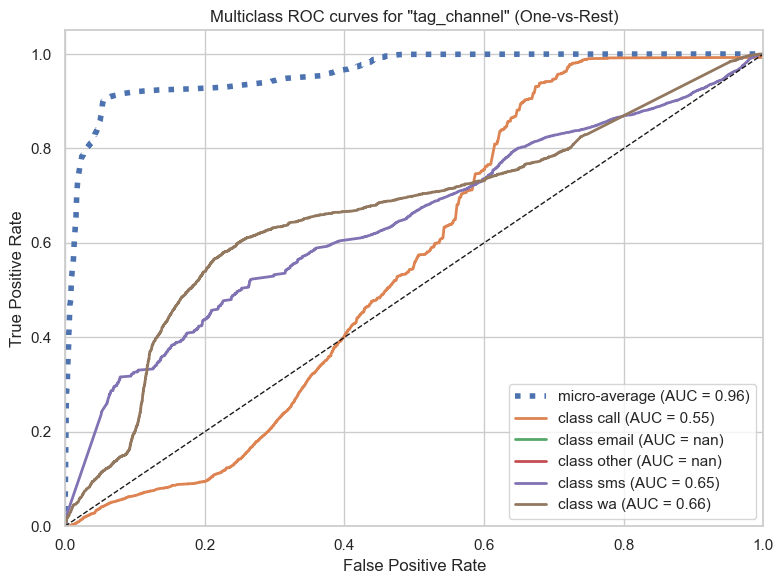

AttributeError: 'range' object has no attribute 'unique'

In [99]:
print("After correlation filter:", len(numeric_cols_filtered), "features left")

# y = df_merged["tag_channel"]
# X = df_merged[numeric_cols_filtered]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )
# print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

y_train = df_merged["tag_channel"]
X_train = df_merged[numeric_cols_filtered]

y_test  = df_merged_test["tag_channel"]
X_test  = df_merged_test[numeric_cols_filtered]

# 2) Вывод размеров
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


# Считаем class_weights
classes = np.unique(y_train)
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    early_stopping_rounds=100,
    use_best_model=True,
    #class_weights=class_weights,
    random_seed=42,
    verbose=50
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
)

print("Best iteration:", model.get_best_iteration())
print("Best eval score:", model.get_best_score())

y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

y_score = model.predict_proba(X_test)
plot_multiclass_roc(y_test, y_score, model.classes_, 'tag_channel')

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test.values, plot_type='bar', class_names=y.unique(), feature_names = X_test.columns)


In [105]:
df_merged.report_date.max(), df_merged_test.report_date.min()

(Timestamp('2024-12-01 00:00:00'), Timestamp('2024-12-08 00:00:00'))

## Пайплайн прогнозирование коммуникаций

In [16]:
MODEL_DIR = "saved_models_timesplit"
PLOT_DIR = "picture_timesplit"
METRICS_DIR = "metrics_timesplit"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

def train_and_evaluate(df, df_test, features, target):
    """Обучить CatBoost на признаках `features` и таргете `target`."""
    # X = df[features]
    # y = df[target]
    
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )
    y_train = df[target]
    X_train = df[features]
    
    y_test  = df_test[target] # df_merged_test[target]
    X_test  = df_test[features]# df_merged_test[features]

    
    # class weights
    classes = np.unique(y_train)
    weights = compute_class_weight("balanced", classes=classes, y=y_train)
    cw = dict(zip(classes, weights))
    
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        eval_metric="MultiClass",
        early_stopping_rounds=100,
        use_best_model=True,
        class_weights=cw,
        random_seed=42,
        verbose=500
    )
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    return model, X_test, y_test

def plot_and_save_roc(model, X_test, y_test, target, out_dir="picture"):
    os.makedirs(out_dir, exist_ok=True)
    classes = model.classes_
    y_score = model.predict_proba(X_test)
    y_bin   = label_binarize(y_test, classes=classes)
    n_classes = y_bin.shape[1]

    plt.figure(figsize=(8, 6))
    auc_dict = {}

    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_bin[:,0], y_score[:,1])
        auc_val = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{classes[1]} (AUC = {auc_val:.2f})')
        auc_dict = {'auc': float(auc_val)}
    else:
        fpr = {}; tpr = {}; 
        for i, cls in enumerate(classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:,i], y_score[:,i])
            auc_dict[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'class {cls} (AUC = {auc_dict[i]:.2f})')
        # micro
        fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
        auc_dict["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"],
                 linestyle=':', linewidth=4,
                 label=f'micro-average (AUC = {auc_dict["micro"]:.2f})')

    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for "{target}"')
    plt.legend(loc="lower right")
    plt.tight_layout()

    path = os.path.join(out_dir, f"roc_{target}.png")
    plt.savefig(path)
    plt.show()
    plt.close()
    print(f"> Saved ROC plot → {path}")

    return auc_dict

def plot_and_save_shap(model, X_test, target, out_dir="picture"):
    os.makedirs(out_dir, exist_ok=True)
    explainer    = shap.TreeExplainer(model)
    shap_values  = explainer.shap_values(X_test)

    shap.summary_plot(
        shap_values,
        X_test.values,
        plot_type='bar',
        class_names=model.classes_,
        feature_names=X_test.columns,
        show=False   # теперь сразу покажет
    )
    plt.title(f'SHAP summary (bar) for "{target}"')
    plt.tight_layout()

    path = os.path.join(out_dir, f"shap_{target}.png")
    plt.savefig(path)
    plt.show()
    plt.close()
    print(f"> Saved SHAP bar-plot → {path}")

def save_and_print_metrics(model, X_test, y_test, roc_auc, target, out_dir="metrics"):
    os.makedirs(out_dir, exist_ok=True)
    y_pred = model.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    y_proba = model.predict_proba(X_test)
    lloss = log_loss(
        y_test,
        y_proba,
        labels=model.classes_   # <- передаём полный список классов
    )
    crep   = classification_report(y_test, y_pred, output_dict=False)

    # Печатаем красиво
    print(f"\n=== Metrics for '{target}' ===")
    print(f"Accuracy          : {acc:.4f}")
    print(f"Multiclass logloss: {lloss:.4f}")
    print("ROC AUC:")
    for k, v in roc_auc.items():
        if k == "micro":
            label = "micro-average"
        elif k == "auc":
            label = "AUC"
        else:
            # для ключей 0,1,2... приводим к int и вытаскиваем класс
            cls = model.classes_[int(k)]
            label = f"class {cls}"
        print(f"  {label:15s}: {v:.4f}")

    print("\nClassification Report:")
    print(crep)

    metrics = {
        "target": target,
        "accuracy": acc,
        "multiclass_logloss": lloss,
        "roc_auc": {str(k): v for k, v in roc_auc.items()},
        "classification_report": classification_report(y_test, y_pred, output_dict=True)
    }
    path = os.path.join(out_dir, f"metrics_{target}.json")
    with open(path, "w") as f:
        json.dump(metrics, f, indent=2, ensure_ascii=False)
    print(f"> Saved metrics JSON → {path}\n")


  0%|                                                    | 0/11 [00:00<?, ?it/s]


=== Processing tag_channel ===
0:	learn: 1.3469620	test: 1.3203465	best: 1.3203465 (0)	total: 1.66s	remaining: 27m 41s
500:	learn: 0.2808912	test: 0.9864762	best: 0.5218560 (31)	total: 11m 40s	remaining: 11m 37s
999:	learn: 0.2639082	test: 1.1188188	best: 0.5218560 (31)	total: 22m 39s	remaining: 0us

bestTest = 0.5218560367
bestIteration = 31

Shrink model to first 32 iterations.


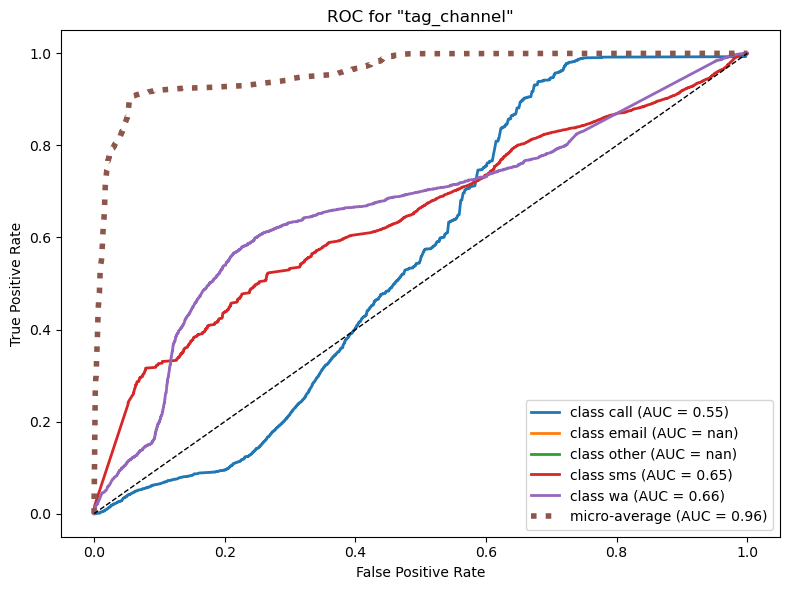

> Saved ROC plot → picture_timesplit/roc_tag_channel.png


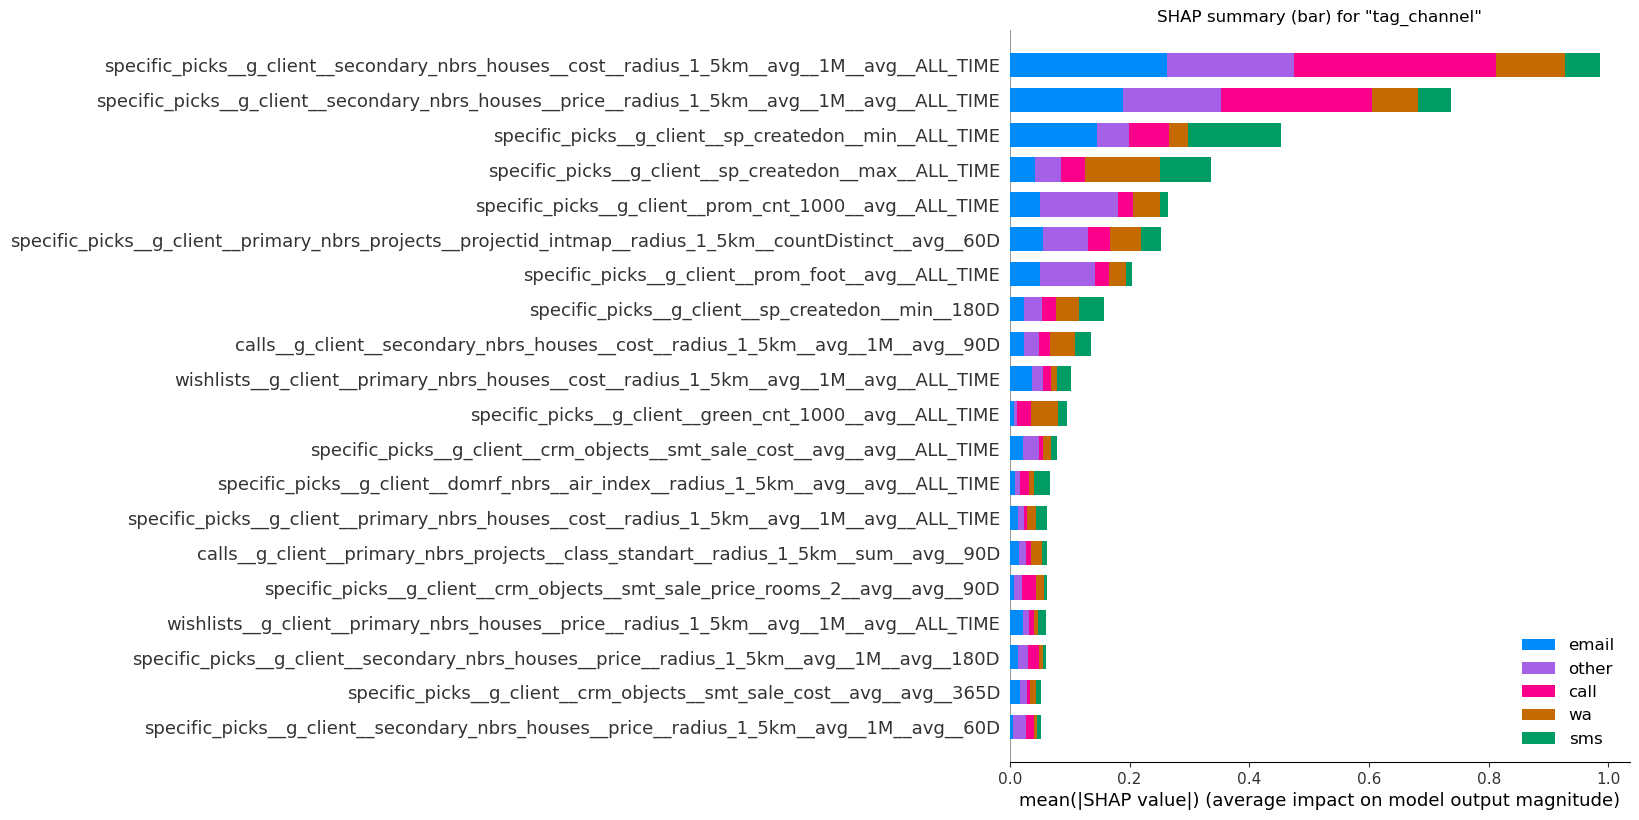

> Saved SHAP bar-plot → picture_timesplit/shap_tag_channel.png

=== Metrics for 'tag_channel' ===
Accuracy          : 0.8295
Multiclass logloss: 0.5219
ROC AUC:
  class call     : 0.5549
  class email    : nan
  class other    : nan
  class sms      : 0.6464
  class wa       : 0.6648
  micro-average  : 0.9597

Classification Report:
              precision    recall  f1-score   support

        call       0.00      0.00      0.00     13059
         sms       0.90      0.92      0.91    168345
          wa       0.06      0.15      0.09      6435

    accuracy                           0.83    187839
   macro avg       0.32      0.36      0.33    187839
weighted avg       0.81      0.83      0.82    187839



  9%|███▋                                    | 1/11 [23:13<3:52:11, 1393.15s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_channel.json

Finished tag_channel.

=== Processing tag_category ===
0:	learn: 0.9248224	test: 0.9234362	best: 0.9234362 (0)	total: 966ms	remaining: 16m 4s
500:	learn: 0.0856806	test: 0.0469141	best: 0.0469119 (499)	total: 7m 3s	remaining: 7m 2s
999:	learn: 0.0834572	test: 0.0428928	best: 0.0428928 (999)	total: 13m 22s	remaining: 0us

bestTest = 0.04289280263
bestIteration = 999



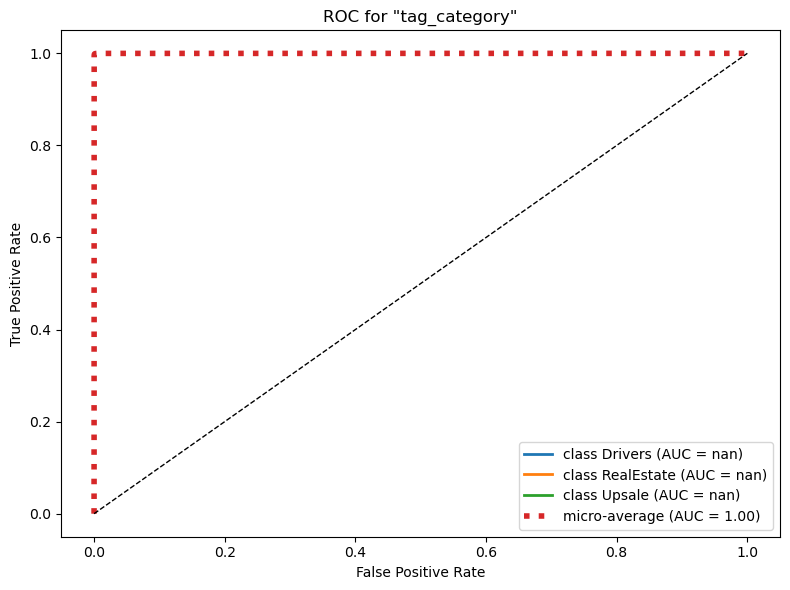

> Saved ROC plot → picture_timesplit/roc_tag_category.png


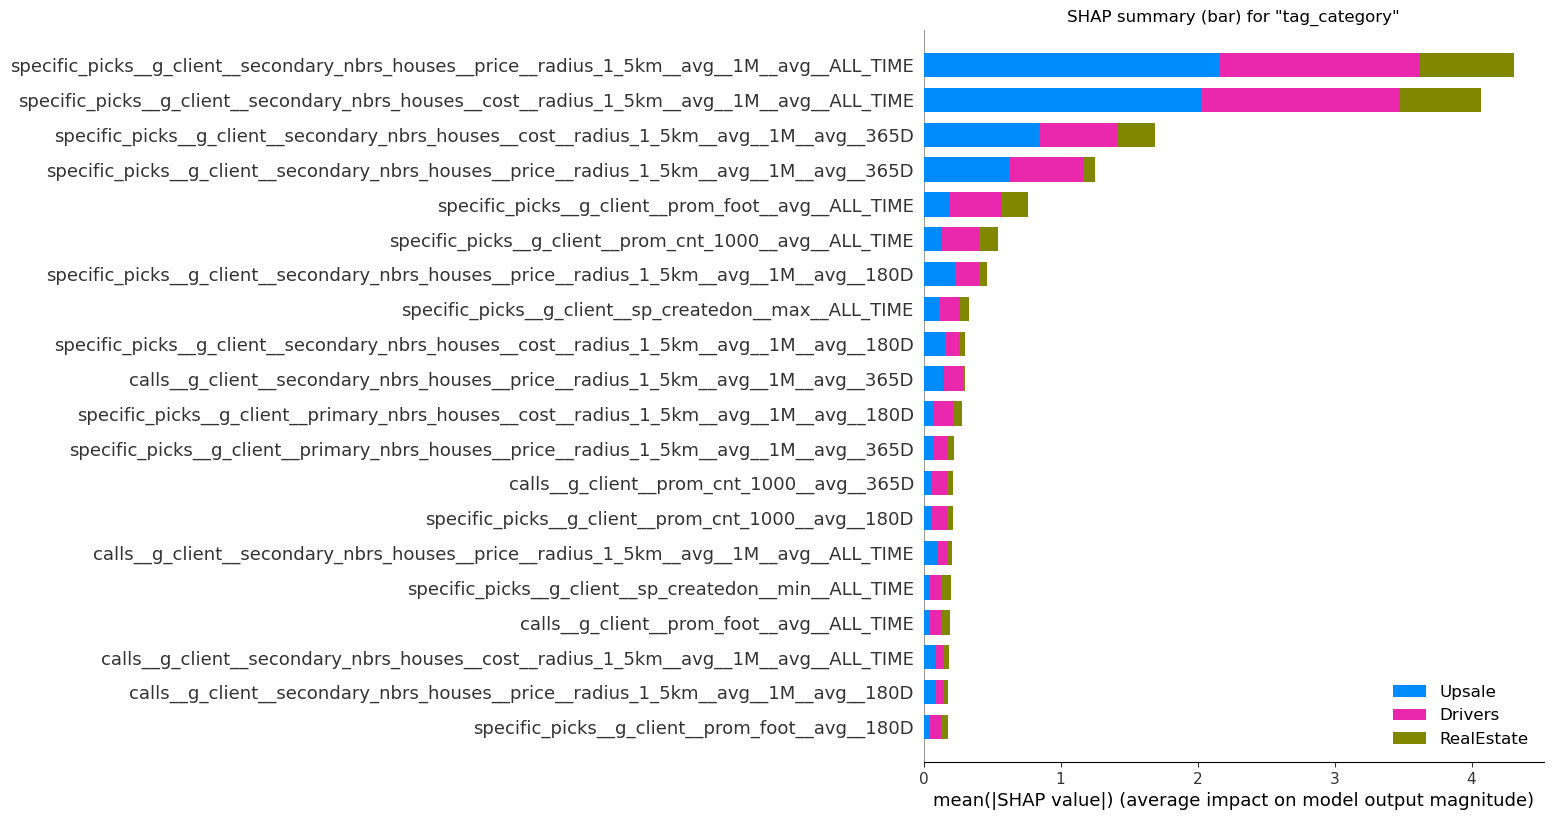

> Saved SHAP bar-plot → picture_timesplit/shap_tag_category.png

=== Metrics for 'tag_category' ===
Accuracy          : 0.9987
Multiclass logloss: 0.0429
ROC AUC:
  class Drivers  : nan
  class RealEstate: nan
  class Upsale   : nan
  micro-average  : 1.0000

Classification Report:
              precision    recall  f1-score   support

  RealEstate       1.00      1.00      1.00    187839
      Upsale       0.00      0.00      0.00         0

    accuracy                           1.00    187839
   macro avg       0.50      0.50      0.50    187839
weighted avg       1.00      1.00      1.00    187839



 18%|███████▎                                | 2/11 [37:02<2:39:11, 1061.27s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_category.json

Finished tag_category.

=== Processing tag_campaign_type ===
0:	learn: 0.9921417	test: 0.9606029	best: 0.9606029 (0)	total: 1.3s	remaining: 21m 35s
500:	learn: 0.2743868	test: 0.1033090	best: 0.1030839 (497)	total: 7m 42s	remaining: 7m 41s
999:	learn: 0.2561334	test: 0.0938775	best: 0.0938775 (999)	total: 14m 49s	remaining: 0us

bestTest = 0.09387750672
bestIteration = 999



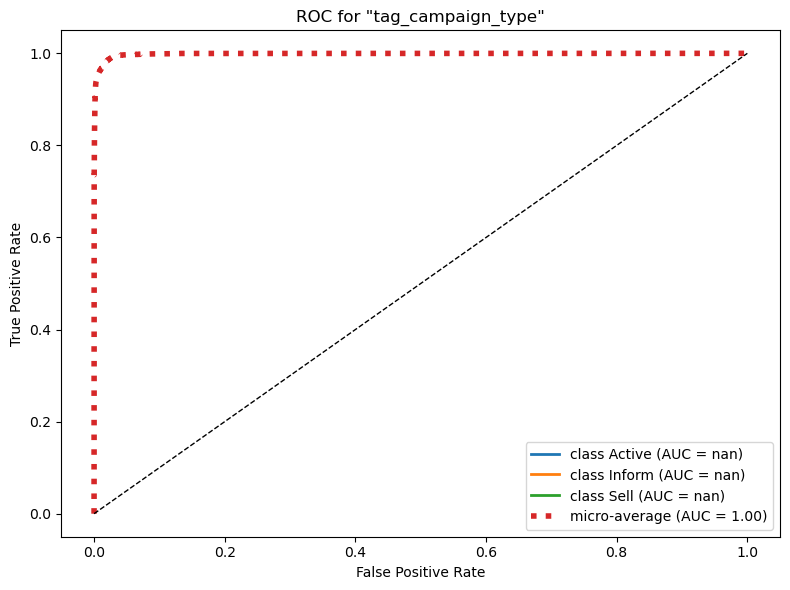

> Saved ROC plot → picture_timesplit/roc_tag_campaign_type.png


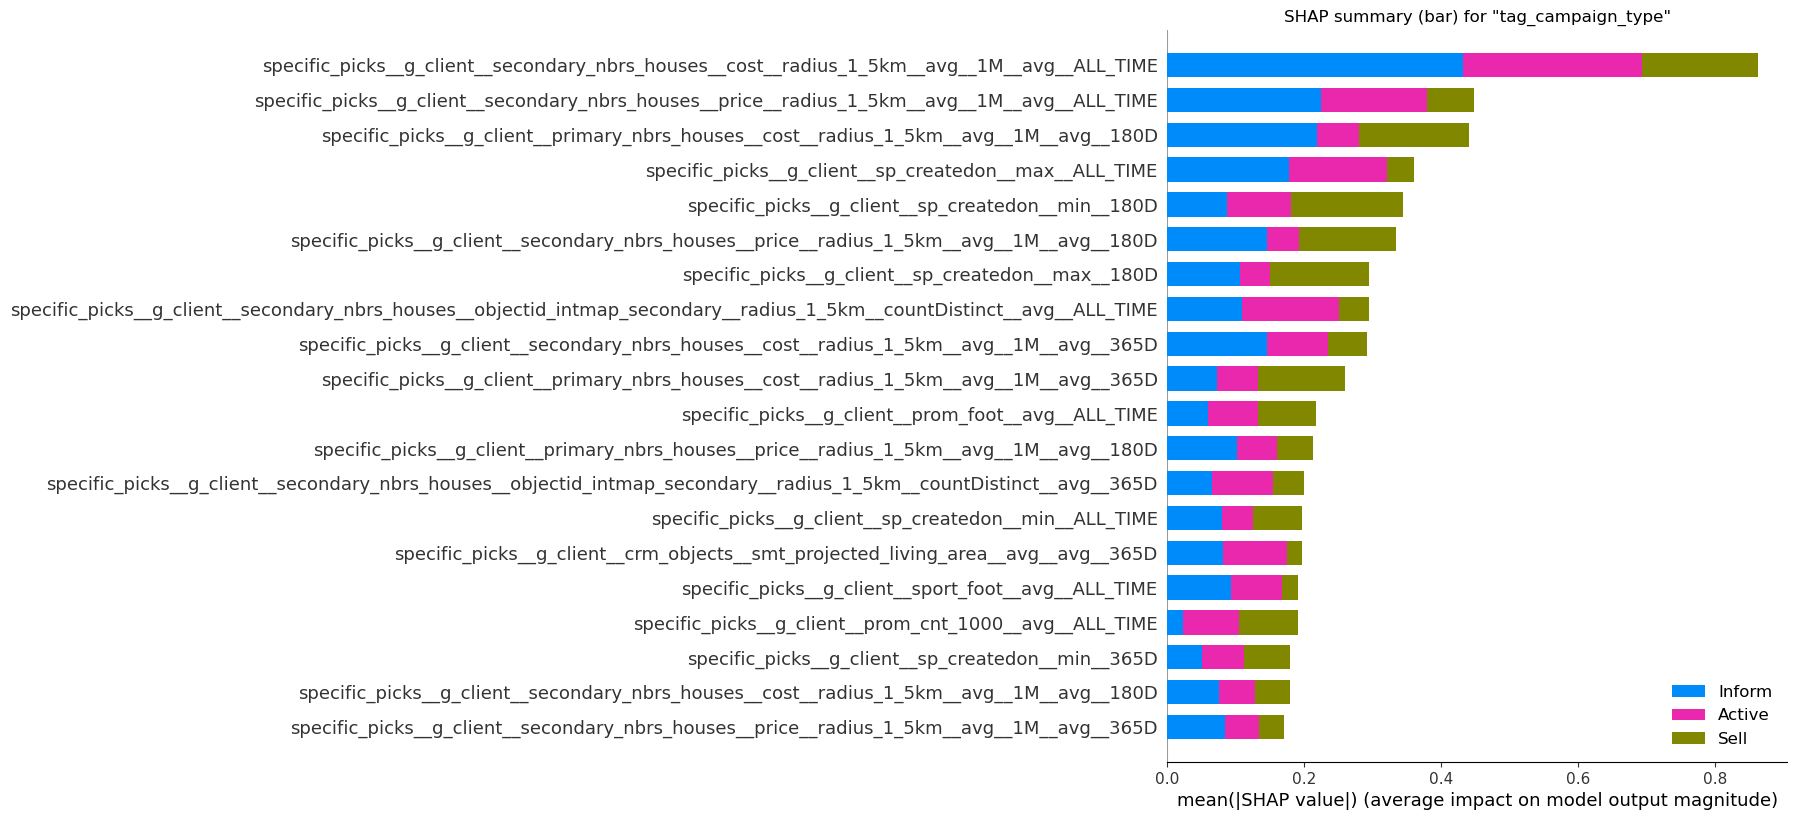

> Saved SHAP bar-plot → picture_timesplit/shap_tag_campaign_type.png

=== Metrics for 'tag_campaign_type' ===
Accuracy          : 0.9726
Multiclass logloss: 0.0939
ROC AUC:
  class Active   : nan
  class Inform   : nan
  class Sell     : nan
  micro-average  : 0.9987

Classification Report:
              precision    recall  f1-score   support

      Active       1.00      0.97      0.99    187839
        Sell       0.00      0.00      0.00         0

    accuracy                           0.97    187839
   macro avg       0.50      0.49      0.49    187839
weighted avg       1.00      0.97      0.99    187839



 27%|███████████▏                             | 3/11 [52:18<2:12:42, 995.28s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_campaign_type.json

Finished tag_campaign_type.

=== Processing tag_project_type ===
0:	learn: 0.6086687	test: 0.6028993	best: 0.6028993 (0)	total: 628ms	remaining: 10m 26s
500:	learn: 0.0827256	test: 0.0214245	best: 0.0214217 (499)	total: 4m 35s	remaining: 4m 34s
999:	learn: 0.0796631	test: 0.0205447	best: 0.0205447 (999)	total: 8m 55s	remaining: 0us

bestTest = 0.02054472339
bestIteration = 999



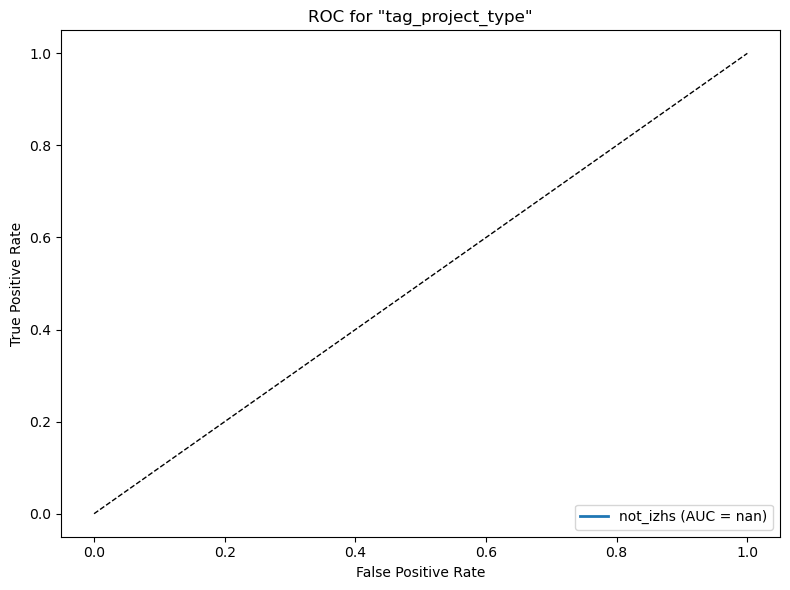

> Saved ROC plot → picture_timesplit/roc_tag_project_type.png


<Figure size 640x480 with 0 Axes>

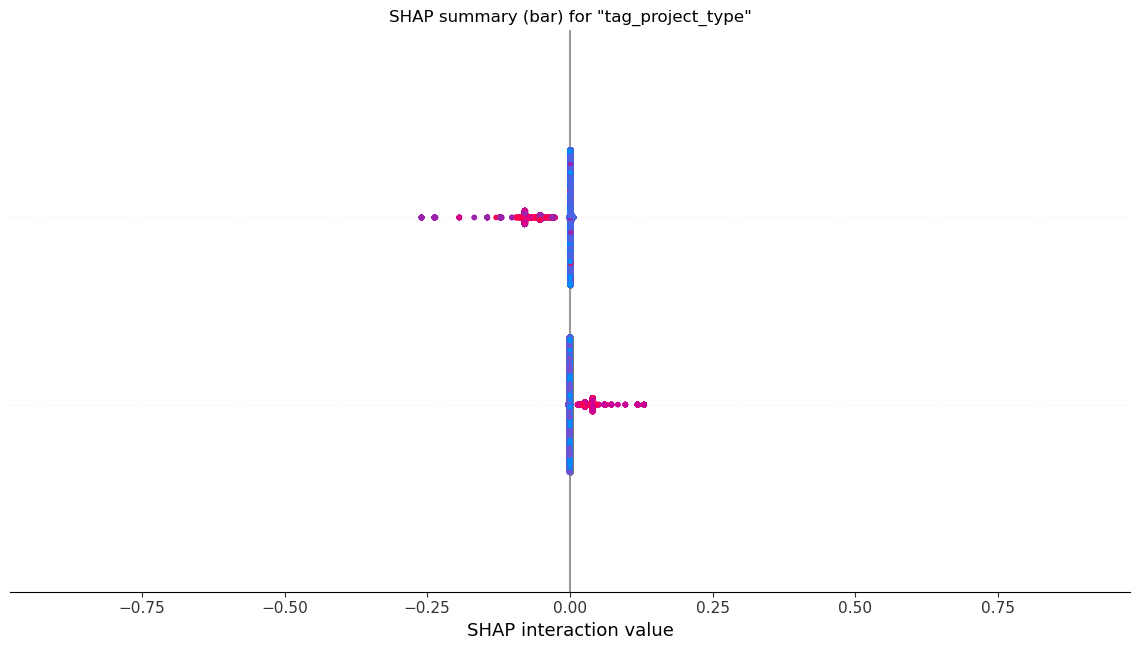

> Saved SHAP bar-plot → picture_timesplit/shap_tag_project_type.png

=== Metrics for 'tag_project_type' ===
Accuracy          : 0.9973
Multiclass logloss: 0.0205
ROC AUC:
  AUC            : nan

Classification Report:
              precision    recall  f1-score   support

        izhs       0.00      0.00      0.00         0
    not_izhs       1.00      1.00      1.00    187839

    accuracy                           1.00    187839
   macro avg       0.50      0.50      0.50    187839
weighted avg       1.00      1.00      1.00    187839



 36%|██████████████▏                        | 4/11 [1:01:41<1:36:10, 824.41s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_project_type.json

Finished tag_project_type.

=== Processing tag_project_region ===
0:	learn: 1.1732723	test: 1.4503276	best: 1.4503276 (0)	total: 1.09s	remaining: 18m 14s
500:	learn: 0.0552725	test: 4.2312313	best: 1.4503276 (0)	total: 9m 56s	remaining: 9m 54s
999:	learn: 0.0441072	test: 4.4138270	best: 1.4503276 (0)	total: 19m 4s	remaining: 0us

bestTest = 1.450327623
bestIteration = 0

Shrink model to first 1 iterations.


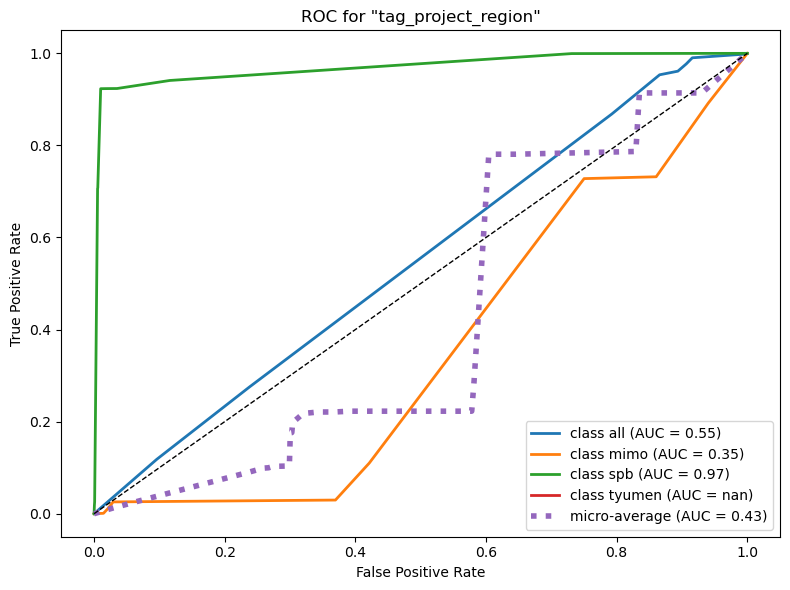

> Saved ROC plot → picture_timesplit/roc_tag_project_region.png


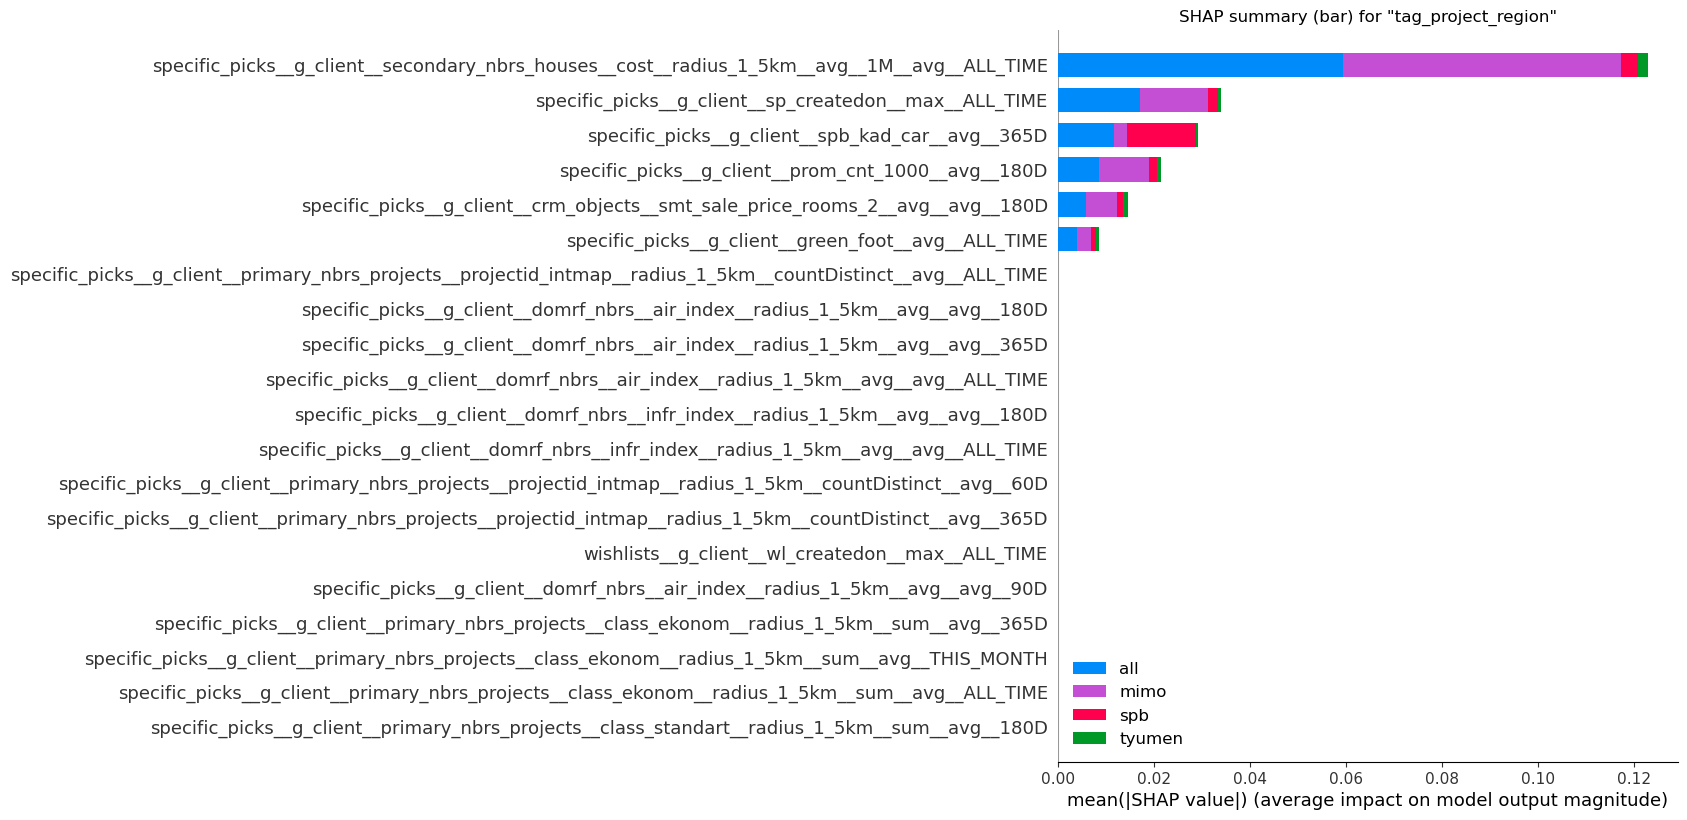

> Saved SHAP bar-plot → picture_timesplit/shap_tag_project_region.png

=== Metrics for 'tag_project_region' ===
Accuracy          : 0.1062
Multiclass logloss: 1.4503
ROC AUC:
  class all      : 0.5494
  class mimo     : 0.3528
  class spb      : 0.9697
  class tyumen   : nan
  micro-average  : 0.4265

Classification Report:
              precision    recall  f1-score   support

         all       0.10      1.00      0.19     19494
        mimo       0.00      0.00      0.00    149314
         spb       0.77      0.03      0.05     19031

    accuracy                           0.11    187839
   macro avg       0.29      0.34      0.08    187839
weighted avg       0.09      0.11      0.02    187839



 45%|█████████████████▋                     | 5/11 [1:21:13<1:34:58, 949.70s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_project_region.json

Finished tag_project_region.

=== Processing tag_discount_flag ===
0:	learn: 0.6264627	test: 0.6167813	best: 0.6167813 (0)	total: 526ms	remaining: 8m 45s
500:	learn: 0.1790078	test: 0.0853022	best: 0.0850830 (442)	total: 4m 41s	remaining: 4m 40s
999:	learn: 0.1715169	test: 0.0846512	best: 0.0835249 (812)	total: 9m 9s	remaining: 0us

bestTest = 0.08352493235
bestIteration = 812

Shrink model to first 813 iterations.


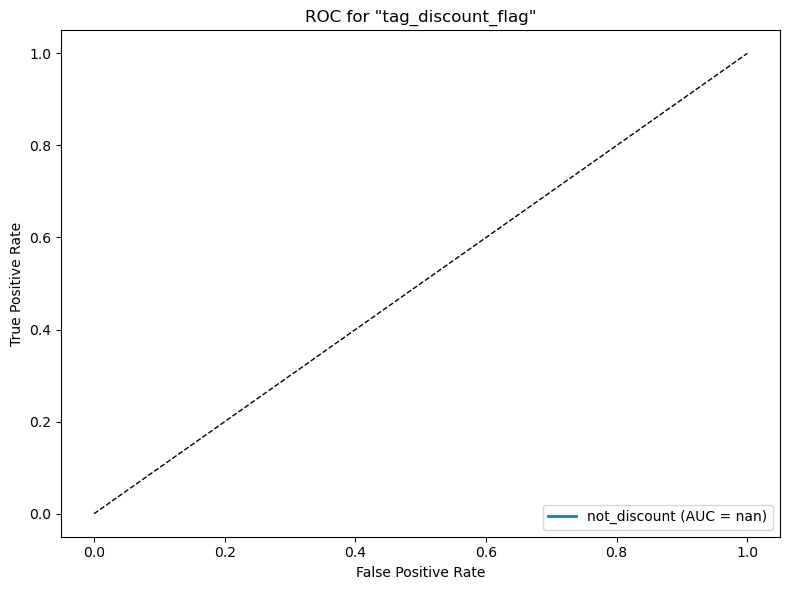

> Saved ROC plot → picture_timesplit/roc_tag_discount_flag.png


<Figure size 640x480 with 0 Axes>

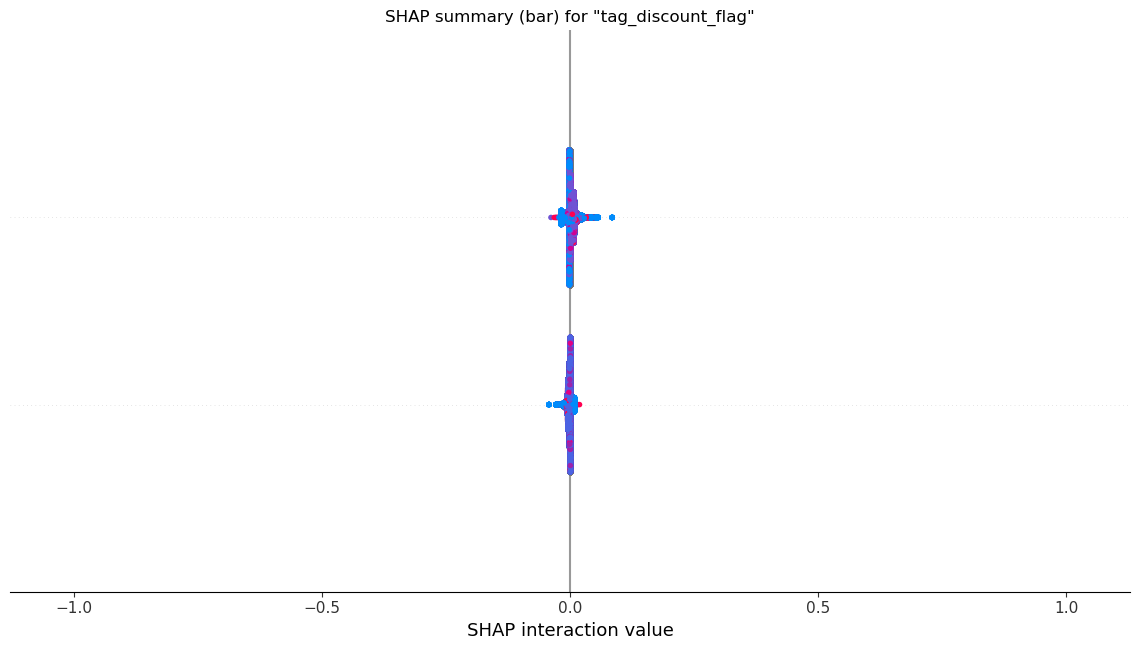

> Saved SHAP bar-plot → picture_timesplit/shap_tag_discount_flag.png

=== Metrics for 'tag_discount_flag' ===
Accuracy          : 0.9979
Multiclass logloss: 0.0835
ROC AUC:
  AUC            : nan

Classification Report:
              precision    recall  f1-score   support

    discount       0.00      0.00      0.00         0
not_discount       1.00      1.00      1.00    187839

    accuracy                           1.00    187839
   macro avg       0.50      0.50      0.50    187839
weighted avg       1.00      1.00      1.00    187839



 55%|█████████████████████▎                 | 6/11 [1:30:47<1:08:30, 822.18s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_discount_flag.json

Finished tag_discount_flag.

=== Processing tag_chain_flag ===
0:	learn: 0.6508712	test: 0.6738753	best: 0.6738753 (0)	total: 615ms	remaining: 10m 14s
500:	learn: 0.2898451	test: 0.6270069	best: 0.5461953 (103)	total: 4m 54s	remaining: 4m 53s
999:	learn: 0.2738141	test: 0.6716500	best: 0.5461953 (103)	total: 9m 42s	remaining: 0us

bestTest = 0.5461952608
bestIteration = 103

Shrink model to first 104 iterations.


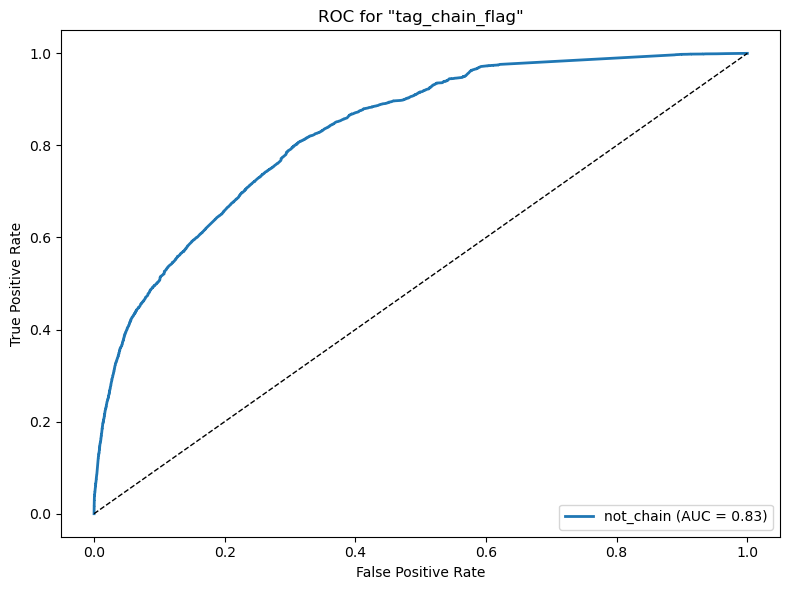

> Saved ROC plot → picture_timesplit/roc_tag_chain_flag.png


<Figure size 640x480 with 0 Axes>

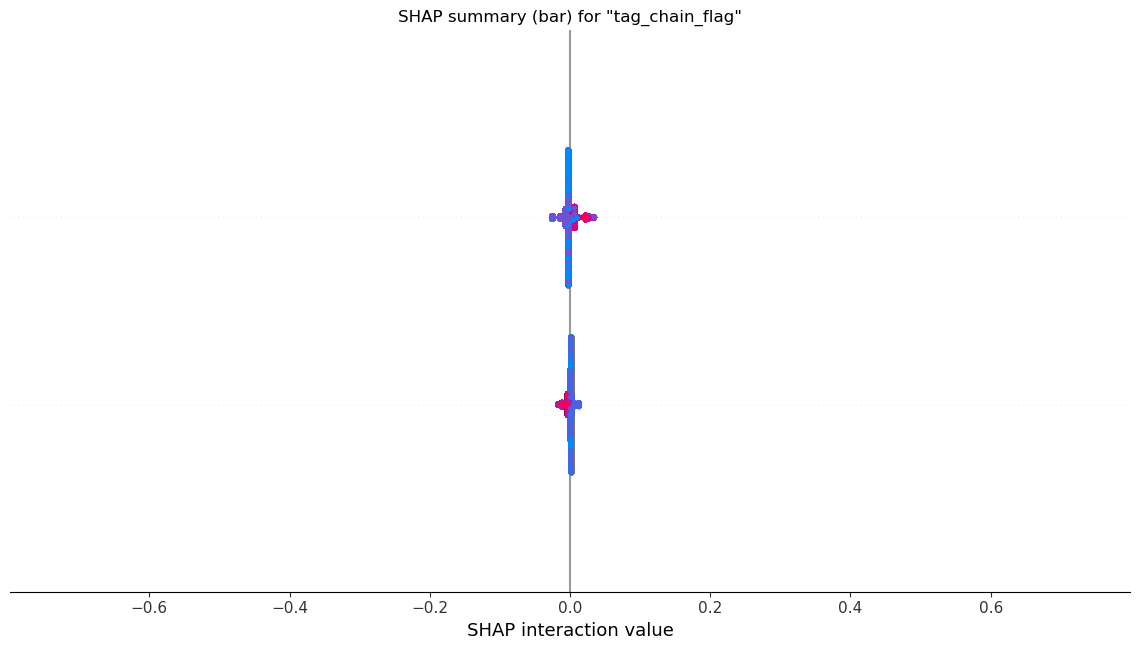

> Saved SHAP bar-plot → picture_timesplit/shap_tag_chain_flag.png

=== Metrics for 'tag_chain_flag' ===
Accuracy          : 0.7205
Multiclass logloss: 0.5462
ROC AUC:
  AUC            : 0.8301

Classification Report:
              precision    recall  f1-score   support

       chain       0.91      0.69      0.78    138181
   not_chain       0.48      0.80      0.60     49658

    accuracy                           0.72    187839
   macro avg       0.69      0.75      0.69    187839
weighted avg       0.79      0.72      0.74    187839



 64%|██████████████████████████               | 7/11 [1:40:54<50:06, 751.62s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_chain_flag.json

Finished tag_chain_flag.

=== Processing tag_model_flag ===
0:	learn: 0.6404033	test: 0.6393142	best: 0.6393142 (0)	total: 869ms	remaining: 14m 28s
500:	learn: 0.2541140	test: 0.2707485	best: 0.2617135 (183)	total: 5m 10s	remaining: 5m 9s
999:	learn: 0.2465781	test: 0.2779050	best: 0.2617135 (183)	total: 9m 44s	remaining: 0us

bestTest = 0.2617134738
bestIteration = 183

Shrink model to first 184 iterations.


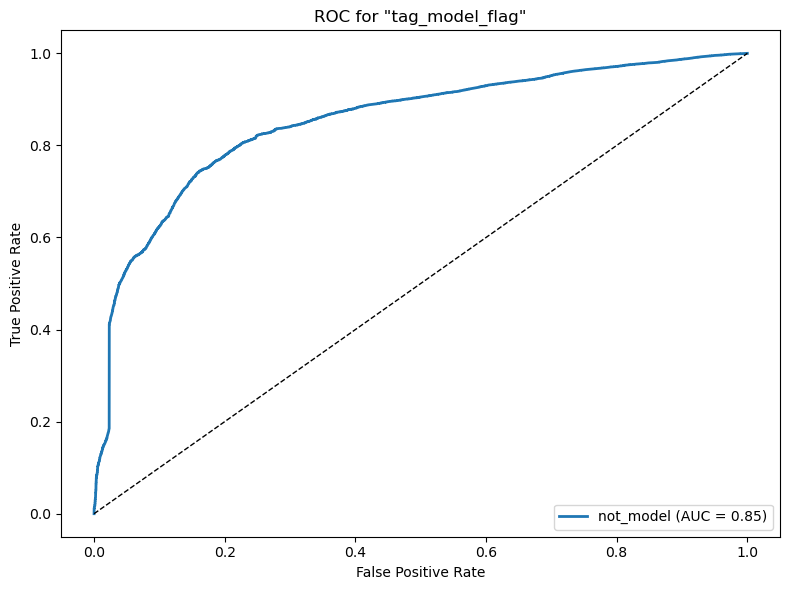

> Saved ROC plot → picture_timesplit/roc_tag_model_flag.png


<Figure size 640x480 with 0 Axes>

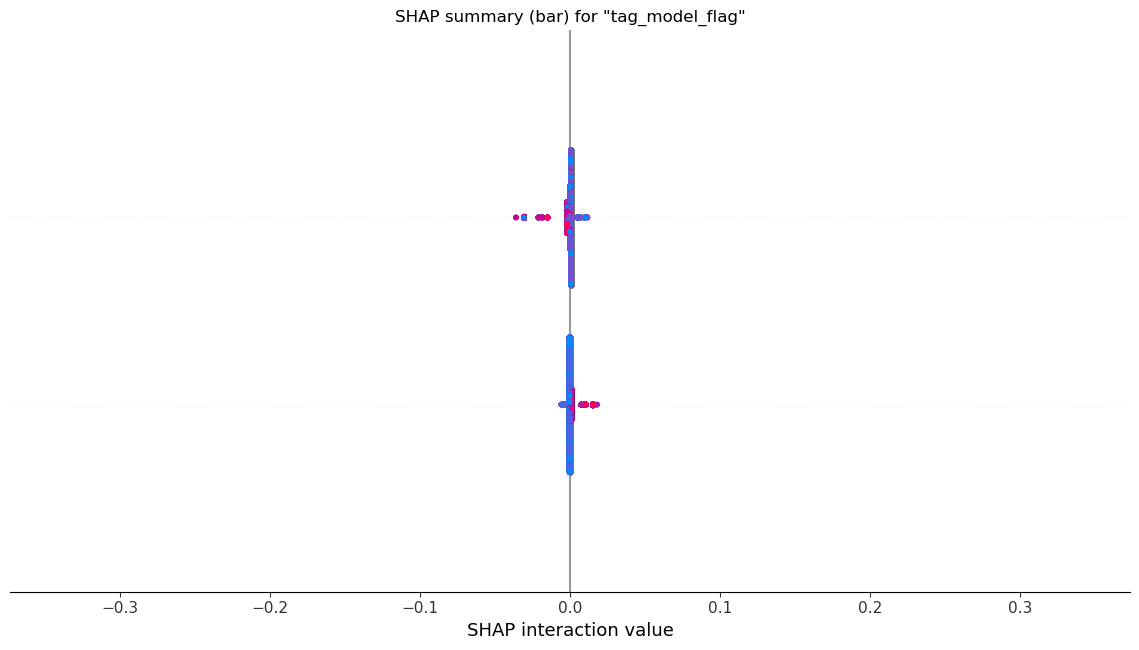

> Saved SHAP bar-plot → picture_timesplit/shap_tag_model_flag.png

=== Metrics for 'tag_model_flag' ===
Accuracy          : 0.8925
Multiclass logloss: 0.2617
ROC AUC:
  AUC            : 0.8527

Classification Report:
              precision    recall  f1-score   support

       model       0.49      0.09      0.15     20143
   not_model       0.90      0.99      0.94    167696

    accuracy                           0.89    187839
   macro avg       0.70      0.54      0.55    187839
weighted avg       0.86      0.89      0.86    187839



 73%|█████████████████████████████▊           | 8/11 [1:51:03<35:18, 706.33s/it]

> Saved metrics JSON → metrics_timesplit/metrics_tag_model_flag.json

Finished tag_model_flag.

=== Processing target_event ===
0:	learn: 1.4485213	test: 1.4466151	best: 1.4466151 (0)	total: 1.75s	remaining: 29m 14s
500:	learn: 0.6163096	test: 1.1566141	best: 0.9051692 (24)	total: 12m 11s	remaining: 12m 8s
999:	learn: 0.5848803	test: 1.2121226	best: 0.9051692 (24)	total: 23m 47s	remaining: 0us

bestTest = 0.9051691618
bestIteration = 24

Shrink model to first 25 iterations.


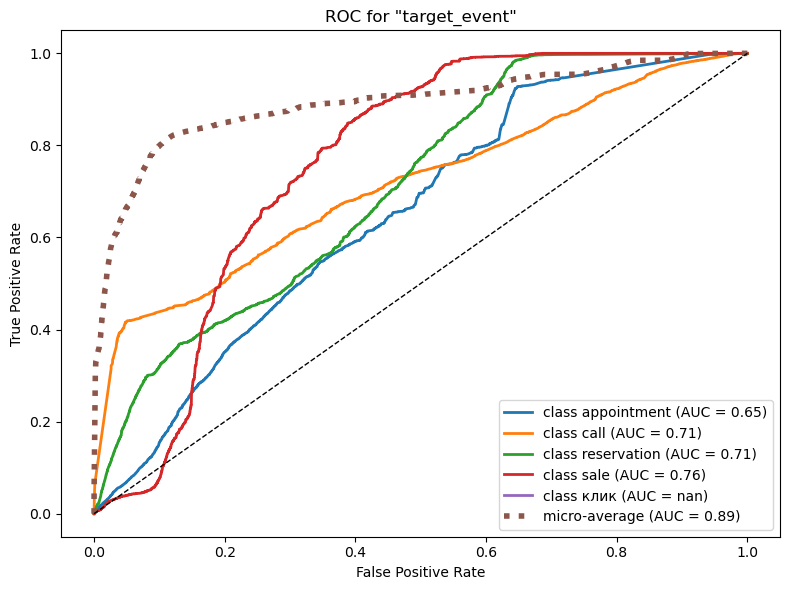

> Saved ROC plot → picture_timesplit/roc_target_event.png


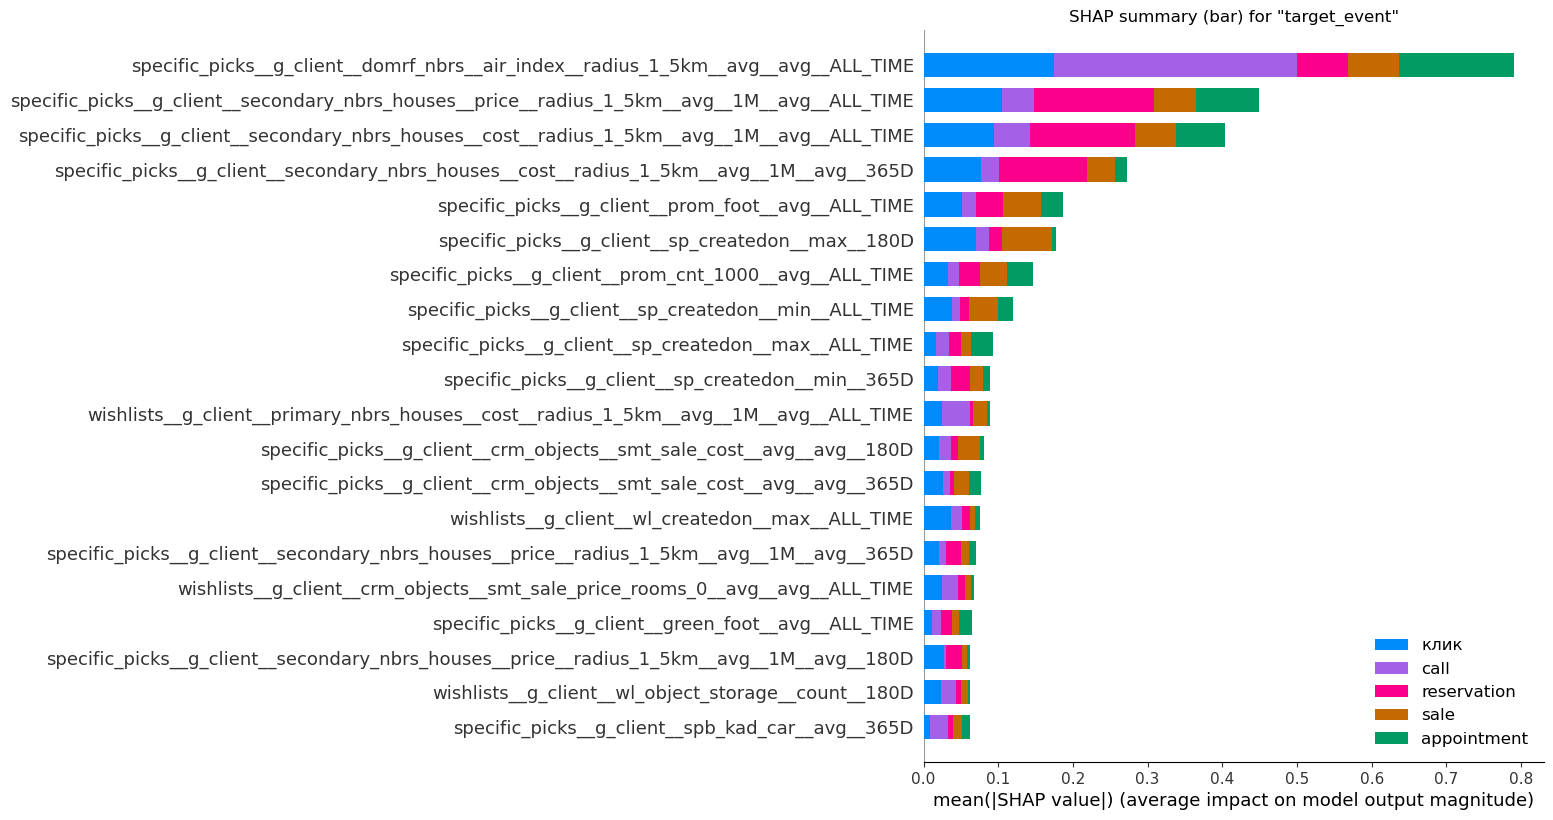

> Saved SHAP bar-plot → picture_timesplit/shap_target_event.png

=== Metrics for 'target_event' ===
Accuracy          : 0.7099
Multiclass logloss: 0.9052
ROC AUC:
  class appointment: 0.6507
  class call     : 0.7150
  class reservation: 0.7082
  class sale     : 0.7614
  class клик     : nan
  micro-average  : 0.8922

Classification Report:
              precision    recall  f1-score   support

 appointment       0.16      0.15      0.15     19041
        call       0.81      0.88      0.84    148202
 reservation       0.00      0.00      0.00     15467
        sale       0.02      0.04      0.03      5129
        клик       0.00      0.00      0.00         0

    accuracy                           0.71    187839
   macro avg       0.20      0.21      0.20    187839
weighted avg       0.65      0.71      0.68    187839



 82%|█████████████████████████████████▌       | 9/11 [2:15:23<31:24, 942.02s/it]

> Saved metrics JSON → metrics_timesplit/metrics_target_event.json

Finished target_event.

=== Processing tag_realestate_flag ===
0:	learn: 0.6103356	test: 0.6128237	best: 0.6128237 (0)	total: 710ms	remaining: 11m 49s
500:	learn: 0.0980897	test: 0.0701350	best: 0.0701350 (500)	total: 4m 43s	remaining: 4m 42s
999:	learn: 0.0954477	test: 0.0653018	best: 0.0652423 (991)	total: 9m 5s	remaining: 0us

bestTest = 0.06524233238
bestIteration = 991

Shrink model to first 992 iterations.


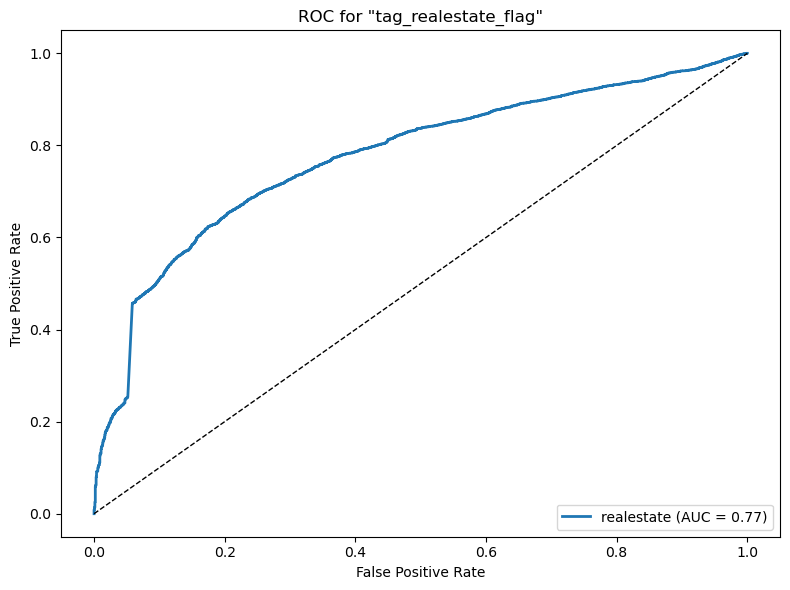

In [ ]:
target_tags = [
    'tag_channel',
    'tag_category',
    'tag_campaign_type',
    'tag_project_type',
    'tag_project_region',
    'tag_discount_flag',
    'tag_chain_flag',
    'tag_model_flag',
    'target_event',
    'tag_realestate_flag',
    'tag_product'
]
numeric_cols_filtered = numeric_cols

for tgt in tqdm(target_tags):
    print(f"\n=== Processing {tgt} ===")
    model, X_test, y_test = train_and_evaluate(df_merged,df_merged_test,  numeric_cols_filtered, tgt)
    
    model.save_model(os.path.join(MODEL_DIR, f"catboost_{tgt}.cbm"))
    roc_auc = plot_and_save_roc(model, X_test, y_test, tgt, PLOT_DIR)

    plot_and_save_shap(model, X_test, tgt, PLOT_DIR)

    save_and_print_metrics(model, X_test, y_test, roc_auc, tgt, METRICS_DIR)

    print(f"Finished {tgt}.") 


In [112]:
MODEL_DIR = "saved_models_timesplit"

models = {}
for tgt in target_tags:
    m = CatBoostClassifier()
    m.load_model(os.path.join(MODEL_DIR, f"catboost_{tgt}.cbm"))
    models[tgt] = m

# Берём 10 строк
df_predict = df_merged.sample(n=10, random_state=42).reset_index(drop=True)
X_pred     = df_predict[numeric_cols_filtered]

results = df_predict.copy()

for tgt, model in models.items():
    raw_pred = model.predict(X_pred)
    pred = np.ravel(raw_pred)
    
    proba = model.predict_proba(X_pred)
    
    # Добавим колонку с предсказанным классом
    results[f"{tgt}_pred"] = pred
    
    # Добавим вероятности для каждого класса
    for cls_idx, cls in enumerate(model.classes_):
        results[f"{tgt}_proba_{cls}"] = proba[:, cls_idx]

display_cols = (
    ["smt_decision_makerid", "delivery_date"] +
    [c for c in results.columns if any(c.startswith(t) for t in target_tags)]
)
results

,smt_decision_makerid,delivery_date_x,hash,campaign_name,segment_name,ab_group,tag_channel,tag_category,tag_campaign_type,tag_product,...,tag_product_proba_furniture_set,tag_product_proba_izhs,tag_product_proba_lost_leads,tag_product_proba_mortgage,tag_product_proba_nbo,tag_product_proba_not_defined,tag_product_proba_realestate,tag_product_proba_start_sales,tag_product_proba_storeroom,tag_product_proba_trade_in
0,45a129bf388295a4e1e375fc21fc0649,2024-10-02,67be0b857cd5999cd77601e5e7e0d4c6,[batch] [241003] [SMS] [СПБ] Первичная недвижи...,CMPG-3557,target,sms,RealEstate,Active,realestate,...,0.013632,0.018707,0.005011,0.031960,0.007666,0.003730,0.889491,0.004291,0.008884,0.005936
1,f2471f1a262951b1a7c00340a26bae5d,2024-10-02,7a4a82f98228acfc5d02458c312a2f12,[batch] [241002] [SMS] Первичная недвижимость ...,CMPG-3552,target,sms,RealEstate,Active,mortgage,...,0.079160,0.019711,0.007308,0.496052,0.008419,0.004894,0.184021,0.004816,0.176369,0.006212
2,2b2e1ce048dceb83b36d0a2cb2a90218,2024-12-06,60c47521627d978cd4a4205c5d733c6b,batch_241205_Pervichnaya_nedvizhimost_Tsepochk...,CMPG-3850,target,sms,RealEstate,Active,realestate,...,0.015308,0.025538,0.004193,0.015176,0.174730,0.004399,0.711132,0.007144,0.009155,0.019894
3,41bd9e21242f8e2fca0dfcde6c6dae95,2024-12-06,232bbf667a1f675db9839ad68d6e78c5,batch_241205_Pervichnaya_nedvizhimost_Tsepochk...,CMPG-3850,control,sms,RealEstate,Active,realestate,...,0.014006,0.010545,0.004266,0.029397,0.098533,0.008495,0.802967,0.006638,0.006215,0.007014
4,b2556a4cb9c4637fdfaecab464a0b6f7,2024-10-15,f4a76cf75e8bc8ea6baedb6055314af8,[batch] [241008] [SMS] [МСК] Первичная недвижи...,CMPG-3589,target,sms,RealEstate,Active,realestate,...,0.014020,0.012910,0.004195,0.019404,0.167899,0.005641,0.738330,0.007391,0.007205,0.010404
5,79e0af70d582df42f738e50b7cf04289,2024-10-01,968cb6fce79f2cbb5855aab443cc1e78,[batch] [241001] [SMS] Первичная недвижимость ...,DSML-1439,control,sms,RealEstate,Active,realestate,...,0.005809,0.018236,0.003364,0.016117,0.039265,0.003987,0.874577,0.003957,0.004341,0.022130
6,24fdce67567745c6e44c7d7c673170fc,2024-10-15,08360fe204c2b3238bfaf1bb1ffda096,[batch] [241008] [SMS] [МСК] Первичная недвижи...,CMPG-3589,target,sms,RealEstate,Active,realestate,...,0.014285,0.012411,0.004210,0.025314,0.129752,0.006607,0.774305,0.006087,0.006455,0.008102
7,e908ac53665a0cc61469fd457941e503,2024-10-11,7cf14de0a967240910e4f78c62cfa0e1,[batch] [241011] [call] Первичная недвижимость...,DSML-1363,target_A,call,RealEstate,Sell,realestate,...,0.201887,0.019970,0.004696,0.014672,0.449471,0.005796,0.130958,0.049990,0.055161,0.006078
8,40456d4f7c4aeecae03afc398d449bc7,2024-10-08,53290412c0d6237f5c211e7c7cdec29d,[batch] [241008] [SMS] [МСК] Первичная недвижи...,CMPG-3590,control,sms,RealEstate,Active,realestate,...,0.010338,0.037024,0.006507,0.017729,0.015832,0.005279,0.871309,0.005472,0.006189,0.015010
9,f4019ebd1349a8f4b949ca9e97656046,2024-10-23,034348b8239dd769358789c52bf47b34,[batch] [241009] [SMS call] Первичная недвижим...,DSML-790,target,sms,RealEstate,Sell,nbo,...,0.017165,0.022662,0.004557,0.018076,0.507286,0.004776,0.377064,0.008701,0.007763,0.018842


In [113]:
# #объединяют df_targets и df_merged, но беру последнее целевое действие
# df_targets_load['report_date'] = pd.to_datetime(df_targets_load['report_date'])

# #Отсортируем df_targets по дате и оставим по одному (последнему) элементу на id
# df_targets_latest = (
#     df_targets_load
#     .sort_values('report_date')                           # сначала старые наверх
#     .drop_duplicates(subset=['smt_decision_makerid'],     # убираем дубли по id
#                      keep='last')                         # оставляем самую позднюю
#     .reset_index(drop=True)
# )

# #Присоединяем к df_merged (левый join, чтобы сохранить все из df_merged)
# df_merged_w_target = df_merged.merge(
#     df_targets_latest,
#     on='smt_decision_makerid',
#     how='left',
#     suffixes=('', '_target')   # чтобы, если есть коллизии имён, расширить колонки из targets
# )

# # Смотрим, сколько строк приклеилось
# matched = df_merged_w_target['event'].notna().sum()
# total   = len(df_merged_w_target)
# print(f"Присоединились {matched} из {total} строк ({matched/total:.2%})")


In [17]:
df_merged['delivery_date_merge'] = pd.to_datetime(df_merged['report_date'])
df_targets_load['delivery_date_targets'] = pd.to_datetime(df_targets_load['report_date'])

target_event_list = ['call', 'appointment', 'sale', 'reservation', 'deal']
df_targets_load.loc[df_targets_load.event == 'deal', 'event'] = 'sale'
df_targets_load = df_targets_load.query("event in @target_event_list")

df_join = df_merged.merge(
    df_targets_load,
    on='smt_decision_makerid',
    how='left'
)

# считаем разницу дней между событиями
df_join['delta_days'] = (
    df_join['delivery_date_targets']
    - df_join['delivery_date_merge']
).dt.days

# оставляем только события в [0,14] дня с момента delivery_date_merge
df_valid = df_join[
    (df_join['delta_days'] >= 0) &
    (df_join['delta_days'] <= 14)
].copy()

# для каждой исходной строки берём самое позднее событие (по delivery_date_targets)
df_valid = (
    df_valid
    .sort_values(['smt_decision_makerid','delivery_date_targets'], ascending=[True, False])
    .drop_duplicates(subset='smt_decision_makerid', keep='first')
)[['smt_decision_makerid', 'delivery_date_merge', 'delivery_date_targets', 'event', 'delta_days']]

df_merged_w_target = df_merged.merge(df_valid, on = ['smt_decision_makerid', 'delivery_date_merge'], how = 'left')

df_merged_w_target = df_merged_w_target.rename(columns = {'event':'event_target_14_day'})
df_merged_w_target['event_target_14_day'] = df_merged_w_target['event_target_14_day'].fillna('no_event')

# target_event_list = ['no_event', 'call', 'appointment', 'sale', 'reservation', 'deal']
# df_merged_w_target.loc[df_merged_w_target.query("event_target_14_day not in @target_event_list").index, 'event_target_14_day'] = 'no_event'
df_merged_w_target['event_target_14_day'] = df_merged_w_target['event_target_14_day'].fillna('no_event')

# сколько строк получили такое событие
matched = df_merged_w_target['delivery_date_targets'].notna().sum()
total   = len(df_merged_w_target)
print(f"Присоединились {matched} из {total} строк ({matched/total:.2%})")


df_merged_test['delivery_date_merge'] = pd.to_datetime(df_merged_test['report_date'])
df_targets_load['delivery_date_targets'] = pd.to_datetime(df_targets_load['report_date'])

target_event_list = ['call', 'appointment', 'sale', 'reservation', 'deal']
df_targets_load.loc[df_targets_load.event == 'deal', 'event'] = 'sale'
df_targets_load = df_targets_load.query("event in @target_event_list")

df_join = df_merged_test.merge(
    df_targets_load,
    on='smt_decision_makerid',
    how='left'
)

# считаем разницу дней между событиями
df_join['delta_days'] = (
    df_join['delivery_date_targets']
    - df_join['delivery_date_merge']
).dt.days

# оставляем только события в [0,14] дня с момента delivery_date_merge
df_valid = df_join[
    (df_join['delta_days'] >= 0) &
    (df_join['delta_days'] <= 14)
].copy()

# для каждой исходной строки берём самое позднее событие (по delivery_date_targets)
df_valid = (
    df_valid
    .sort_values(['smt_decision_makerid','delivery_date_targets'], ascending=[True, False])
    .drop_duplicates(subset='smt_decision_makerid', keep='first')
)[['smt_decision_makerid', 'delivery_date_merge', 'delivery_date_targets', 'event', 'delta_days']]

df_merged_w_target_test = df_merged_test.merge(df_valid, on = ['smt_decision_makerid', 'delivery_date_merge'], how = 'left')

df_merged_w_target_test = df_merged_w_target_test.rename(columns = {'event':'event_target_14_day'})
df_merged_w_target_test['event_target_14_day'] = df_merged_w_target_test['event_target_14_day'].fillna('no_event')

# target_event_list = ['no_event', 'call', 'appointment', 'sale', 'reservation', 'deal']
# df_merged_w_target.loc[df_merged_w_target.query("event_target_14_day not in @target_event_list").index, 'event_target_14_day'] = 'no_event'
df_merged_w_target_test['event_target_14_day'] = df_merged_w_target_test['event_target_14_day'].fillna('no_event')

# сколько строк получили такое событие
matched = df_merged_w_target_test['delivery_date_targets'].notna().sum()
total   = len(df_merged_w_target_test)
print(f"Присоединились {matched} из {total} строк ({matched/total:.2%})")


Присоединились 75462 из 1087341 строк (6.94%)
Присоединились 17808 из 187839 строк (9.48%)


In [18]:
df_merged_w_target.event_target_14_day.value_counts()

event_target_14_day
no_event       1011879
call             71901
sale              2052
appointment        952
reservation        557
Name: count, dtype: int64

In [19]:
df_merged.target_event.value_counts()


target_event
call           693294
appointment    160109
клик            91814
sale            90938
reservation     51186
Name: count, dtype: int64

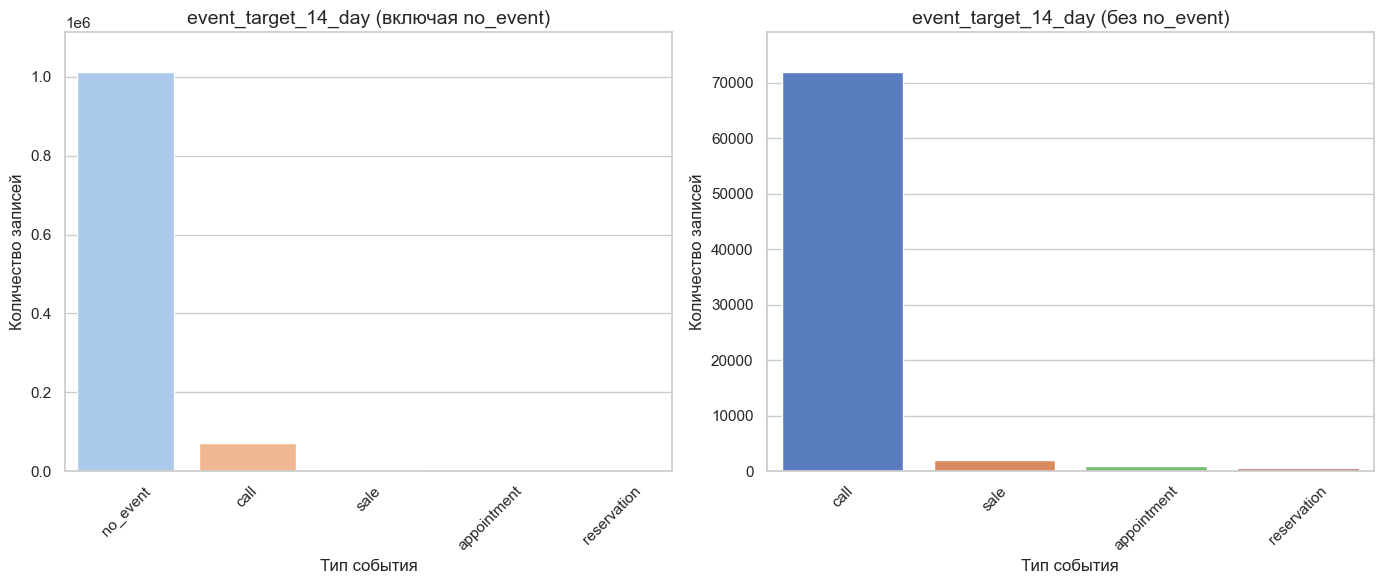

In [20]:
sns.set_theme(style="whitegrid")

# Подготовка данных
all_counts = df_merged_w_target['event_target_14_day'].value_counts()
no_event_excl = df_merged_w_target[df_merged_w_target['event_target_14_day'] != 'no_event']
ex_counts = no_event_excl['event_target_14_day'].value_counts()

# Создаём фигуру с двумя осями без общей шкалы y
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# График 1: включая no_event
sns.barplot(
    x=all_counts.index,
    y=all_counts.values,
    ax=axes[0],
    palette="pastel"
)
axes[0].set_title("event_target_14_day (включая no_event)", fontsize=14)
axes[0].set_xlabel("Тип события", fontsize=12)
axes[0].set_ylabel("Количество записей", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, all_counts.values.max() * 1.1)  # Y-лимит чуть выше максимума

# График 2: без no_event
sns.barplot(
    x=ex_counts.index,
    y=ex_counts.values,
    ax=axes[1],
    palette="muted"
)
axes[1].set_title("event_target_14_day (без no_event)", fontsize=14)
axes[1].set_xlabel("Тип события", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylabel("Количество записей", fontsize=12)
axes[1].set_ylim(0, ex_counts.values.max() * 1.1)  # независимая шкала Y

# Общий заголовок
#plt.suptitle("Сравнение распределения event_target_14_day\nс разными шкалами оси Y", 
#             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()



=== Processing event_target_14_day ===
0:	learn: 1.5752461	test: 1.5856332	best: 1.5856332 (0)	total: 1.65s	remaining: 27m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.43451704
bestIteration = 62

Shrink model to first 63 iterations.


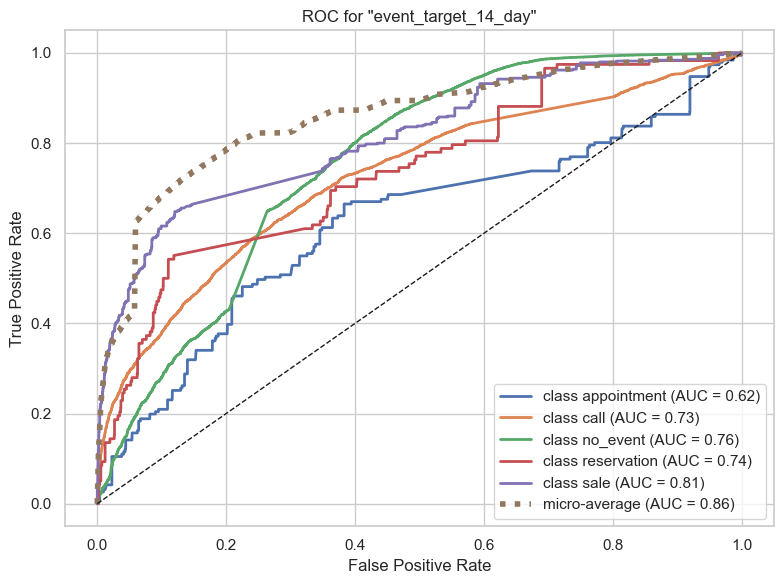

> Saved ROC plot → picture_timesplit/roc_event_target_14_day.png


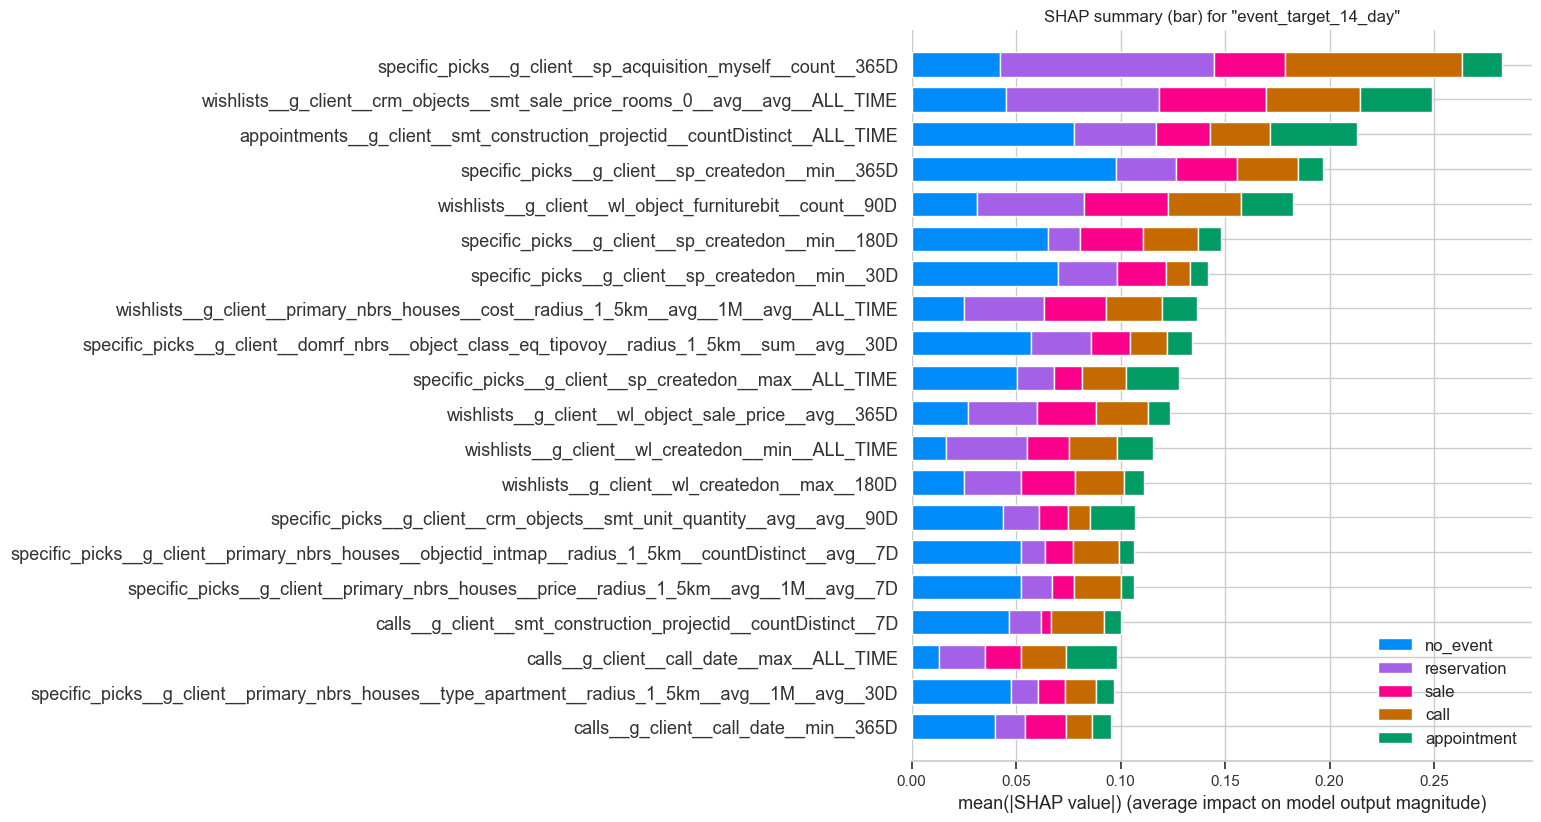

> Saved SHAP bar-plot → picture_timesplit/shap_event_target_14_day.png

=== Metrics for 'event_target_14_day' ===
Accuracy          : 0.6564
Multiclass logloss: 1.1884
ROC AUC:
  class appointment: 0.6200
  class call     : 0.7262
  class no_event : 0.7566
  class reservation: 0.7397
  class sale     : 0.8126
  micro-average  : 0.8565

Classification Report:
              precision    recall  f1-score   support

 appointment       0.00      0.17      0.01       191
        call       0.20      0.43      0.28     16999
    no_event       0.96      0.68      0.79    170031
 reservation       0.00      0.22      0.01       118
        sale       0.02      0.49      0.04       500

    accuracy                           0.66    187839
   macro avg       0.24      0.40      0.23    187839
weighted avg       0.88      0.66      0.74    187839

> Saved metrics JSON → metrics_timesplit/metrics_event_target_14_day.json

Finished event_target_14_day.


In [21]:
tgt = 'event_target_14_day'

print(f"\n=== Processing {tgt} ===")
model, X_test, y_test = train_and_evaluate(df_merged_w_target, df_merged_w_target_test, numeric_cols_filtered, tgt)
model.save_model(os.path.join(MODEL_DIR, f"catboost_{tgt}.cbm"))

roc_auc = plot_and_save_roc(model, X_test, y_test, tgt, PLOT_DIR)

plot_and_save_shap(model, X_test, tgt, PLOT_DIR)

save_and_print_metrics(model, X_test, y_test, roc_auc, tgt, METRICS_DIR)

print(f"Finished {tgt}.") 


=== Processing event_target_14_day ===
0:	learn: 1.2824844	test: 1.2918521	best: 1.2918521 (0)	total: 1.43s	remaining: 23m 45s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3115654543
bestIteration = 43

Shrink model to first 44 iterations.


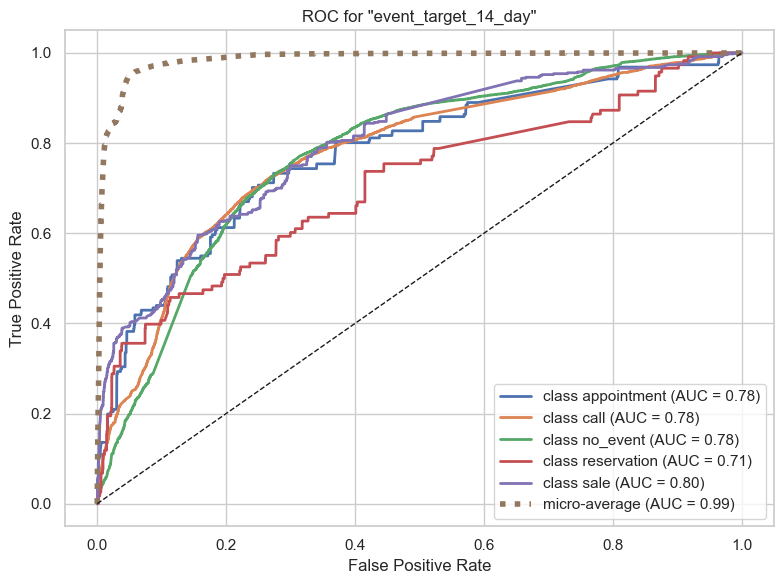

> Saved ROC plot → picture_timesplit_optuna/roc_event_target_14_day.png


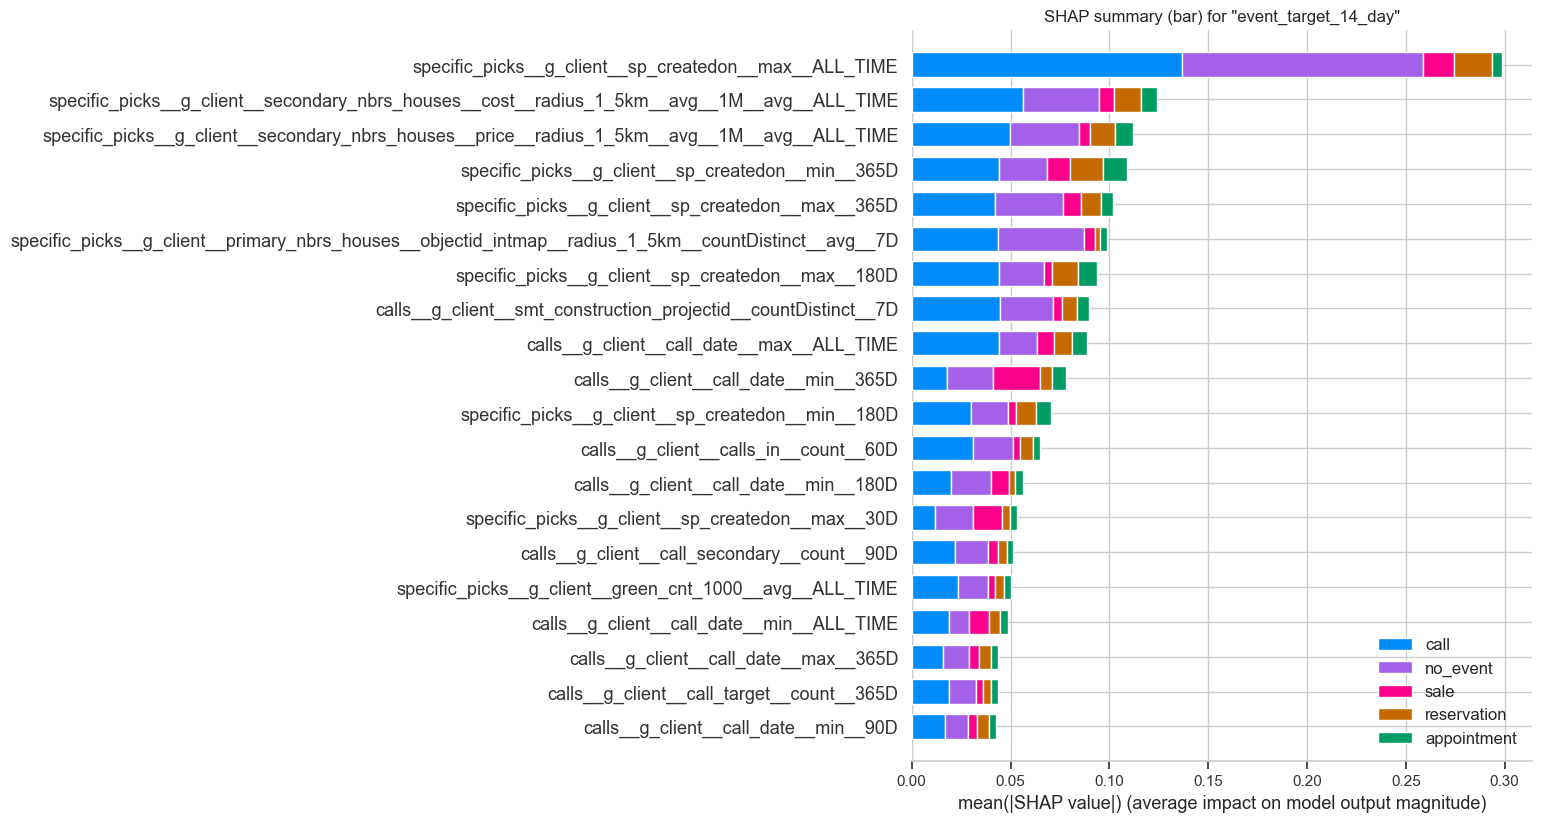

> Saved SHAP bar-plot → picture_timesplit_optuna/shap_event_target_14_day.png

=== Metrics for 'event_target_14_day' ===
Accuracy          : 0.8654
Multiclass logloss: 0.3116
ROC AUC:
  class appointment: 0.7789
  class call     : 0.7775
  class no_event : 0.7779
  class reservation: 0.7065
  class sale     : 0.7987
  micro-average  : 0.9854

Classification Report:
              precision    recall  f1-score   support

 appointment       0.00      0.00      0.00       191
        call       0.29      0.31      0.30     16999
    no_event       0.93      0.92      0.93    170031
 reservation       0.00      0.00      0.00       118
        sale       0.00      0.00      0.00       500

    accuracy                           0.87    187839
   macro avg       0.24      0.25      0.25    187839
weighted avg       0.87      0.87      0.87    187839

> Saved metrics JSON → metrics_timesplit_optuna/metrics_event_target_14_day.json

Finished event_target_14_day.


In [105]:
#модель без балансировки

def train_and_evaluate_wo_cw(df, df_test, features, target):
    """Обучить CatBoost на признаках `features` и таргете `target`."""
    # X = df[features]
    # y = df[target]
    
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )
    y_train = df[target]
    X_train = df[features]
    
    y_test  = df_test[target] # df_merged_test[target]
    X_test  = df_test[features]# df_merged_test[features]

    
    # class weights
    classes = np.unique(y_train)
    weights = compute_class_weight("balanced", classes=classes, y=y_train)
    cw = dict(zip(classes, weights))
    
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function="MultiClass",
        eval_metric="MultiClass",
        early_stopping_rounds=100,
        use_best_model=True,
        #class_weights=cw,
        random_seed=42,
        verbose=500
    )
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    return model, X_test, y_test


tgt = 'event_target_14_day'

print(f"\n=== Processing {tgt} ===")
model, X_test, y_test = train_and_evaluate_wo_cw(df_merged_w_target, df_merged_w_target_test, numeric_cols_filtered, tgt)
model.save_model(os.path.join(MODEL_DIR, f"catboost_{tgt}.cbm"))

roc_auc = plot_and_save_roc(model, X_test, y_test, tgt, PLOT_DIR)

plot_and_save_shap(model, X_test, tgt, PLOT_DIR)

save_and_print_metrics(model, X_test, y_test, roc_auc, tgt, METRICS_DIR)

print(f"Finished {tgt}.") 

## Подбор гиперапараметров

In [107]:
import optuna
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

def objective(trial, df, df_test, features, target):
    # train / val split уже сделан заранее:
    X_tr, y_tr = df[features], df[target]
    X_val, y_val = df_test[features], df_test[target]

    # предлагаемые гиперпараметры
    params = {
        'iterations': trial.suggest_int('iterations', 200, 2000, step=200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 100),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'MultiClass',
        'random_seed': 42,
        'verbose': 0,
        'use_best_model': True,
        'early_stopping_rounds': 50,
    }

    # class weights для компенсации дисбаланса
    classes = np.unique(y_tr)
    weights = compute_class_weight("balanced", classes=classes, y=y_tr)
    params['class_weights'] = dict(zip(classes, weights))

    # обучаем
    model = CatBoostClassifier(**params)
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))

    # предсказания на валидации
    y_pred = model.predict(X_val)
    # считаем макро-F1
    return f1_score(y_val, y_pred, average='macro')


def tune_model(df, df_test, features, target, n_trials=30):
    """Запускает Optuna-стади для макро-F1."""
    study = optuna.create_study(direction='maximize')
    func  = lambda trial: objective(trial, df, df_test, features, target)
    study.optimize(func, n_trials=n_trials, show_progress_bar=True)
    print("  Best params:", study.best_params)
    return study.best_params


def train_and_evaluate_optuna(df, df_test, features, target, n_trials=30):
    """Подбирает гиперпараметры по макро-F1 и обучает финальную модель."""
    best_params = tune_model(df, df_test, features, target, n_trials)

    # строим финальную модель на полном тренировочном сете
    X_train, y_train = df[features], df[target]
    X_val,   y_val   = df_test[features], df_test[target]

    # добавляем веса классов
    classes = np.unique(y_train)
    weights = compute_class_weight("balanced", classes=classes, y=y_train)
    cw = dict(zip(classes, weights))

    # финальный набор параметров
    final_params = {
        **best_params,
        'loss_function': 'MultiClass',
        'class_weights': cw,
        'use_best_model': True,
        'early_stopping_rounds': 100,
        'random_seed': 42,
        'verbose': 500
    }

    model = CatBoostClassifier(**final_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    return model, X_val, y_val


In [108]:
MODEL_DIR = "saved_models_timesplit_optuna"
PLOT_DIR = "picture_timesplit_optuna"
METRICS_DIR = "metrics_timesplit_optuna"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

target_tags = [
    'event_target_14_day'
]

for tgt in tqdm(target_tags):
    print(f"\n=== Tuning+Training {tgt} ===")
    model, X_test, y_test = train_and_evaluate_optuna(
        df_merged_w_target, df_merged_w_target_test, numeric_cols_filtered, tgt,
        n_trials=20 
    )
    model.save_model(os.path.join(MODEL_DIR, f"catboost_{tgt}.cbm"))

    roc_auc = plot_and_save_roc(model, X_test, y_test, tgt, PLOT_DIR)
    plot_and_save_shap(model, X_test, tgt, PLOT_DIR)
    save_and_print_metrics(model, X_test, y_test, roc_auc, tgt, METRICS_DIR)
    print(f"Finished {tgt}.\n")
  
#Best params: {'iterations': 1000, 'learning_rate': 0.03157510698961373, 'depth': 4, 'l2_leaf_reg': 0.7884639215055526, 'border_count': 47}


  0%|                                                     | 0/1 [00:00<?, ?it/s][I 2025-05-18 14:45:14,126] A new study created in memory with name: no-name-92410348-dd61-4917-bbcf-102d072fc780



=== Tuning+Training event_target_14_day ===


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|                                                     | 0/1 [03:51<?, ?it/s]

[I 2025-05-18 14:49:05,791] Trial 0 finished with value: 0.22589774575129917 and parameters: {'iterations': 200, 'learning_rate': 0.11741315573370258, 'depth': 5, 'l2_leaf_reg': 0.04250197718096039, 'border_count': 185}. Best is trial 0 with value: 0.22589774575129917.


  0%|                                                     | 0/1 [06:36<?, ?it/s]

[I 2025-05-18 14:51:50,971] Trial 1 finished with value: 0.22593947012636156 and parameters: {'iterations': 1000, 'learning_rate': 0.11128352899883055, 'depth': 6, 'l2_leaf_reg': 0.002255153019685293, 'border_count': 167}. Best is trial 1 with value: 0.22593947012636156.


  0%|                                                     | 0/1 [14:02<?, ?it/s]

[I 2025-05-18 14:59:17,003] Trial 2 finished with value: 0.23000464185985642 and parameters: {'iterations': 1600, 'learning_rate': 0.07784624201716447, 'depth': 10, 'l2_leaf_reg': 0.664829140567914, 'border_count': 48}. Best is trial 2 with value: 0.23000464185985642.


  0%|                                                     | 0/1 [25:05<?, ?it/s]

[I 2025-05-18 15:10:19,379] Trial 3 finished with value: 0.2301853559169394 and parameters: {'iterations': 1000, 'learning_rate': 0.034538204709560025, 'depth': 9, 'l2_leaf_reg': 0.011990976924293646, 'border_count': 178}. Best is trial 3 with value: 0.2301853559169394.


  0%|                                                     | 0/1 [26:57<?, ?it/s]

[I 2025-05-18 15:12:12,109] Trial 4 finished with value: 0.21358826055543828 and parameters: {'iterations': 600, 'learning_rate': 0.6427585082655994, 'depth': 4, 'l2_leaf_reg': 97.84041072905943, 'border_count': 246}. Best is trial 3 with value: 0.2301853559169394.


  0%|                                                     | 0/1 [37:16<?, ?it/s]

[I 2025-05-18 15:22:30,574] Trial 5 finished with value: 0.2258667332158489 and parameters: {'iterations': 1800, 'learning_rate': 0.01816405286135306, 'depth': 6, 'l2_leaf_reg': 0.018708236840861762, 'border_count': 216}. Best is trial 3 with value: 0.2301853559169394.


  0%|                                                   | 0/1 [1:03:46<?, ?it/s]

[I 2025-05-18 15:49:00,339] Trial 6 finished with value: 0.22998117495783324 and parameters: {'iterations': 1600, 'learning_rate': 0.010030359398572084, 'depth': 9, 'l2_leaf_reg': 1.6853843813925833, 'border_count': 82}. Best is trial 3 with value: 0.2301853559169394.


  0%|                                                   | 0/1 [3:21:30<?, ?it/s]

[I 2025-05-18 18:06:44,442] Trial 7 finished with value: 0.22732725088484415 and parameters: {'iterations': 1400, 'learning_rate': 0.00188698822228068, 'depth': 9, 'l2_leaf_reg': 77.96040929626605, 'border_count': 141}. Best is trial 3 with value: 0.2301853559169394.


  0%|                                                   | 0/1 [3:54:29<?, ?it/s]

[I 2025-05-18 18:39:43,314] Trial 8 finished with value: 0.2316137979266712 and parameters: {'iterations': 1600, 'learning_rate': 0.001835293751715677, 'depth': 4, 'l2_leaf_reg': 0.6457071283024282, 'border_count': 104}. Best is trial 8 with value: 0.2316137979266712.


  0%|                                                   | 0/1 [5:33:23<?, ?it/s]

[W 2025-05-18 20:18:37,124] Trial 9 failed with parameters: {'iterations': 2000, 'learning_rate': 0.0026108692520818767, 'depth': 7, 'l2_leaf_reg': 0.7441494880099941, 'border_count': 147} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/f5/d0q56ywx4xsgqjxcb7188pb40000gn/T/ipykernel_43029/2497792837.py", line 44, in <lambda>
    func  = lambda trial: objective(trial, df, df_test, features, target)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/f5/d0q56ywx4xsgqjxcb7188pb40000gn/T/ipykernel_43029/2497792837.py", line 33, in objective
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
  File "/opt/anaconda3/lib/python3.12/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_f



KeyboardInterrupt



In [123]:
model

In [127]:
# for elem in df_merged.columns:
#     print(elem)

In [104]:
target_tags = [
    'tag_channel',
    'tag_category',
    'tag_campaign_type',
    'tag_product',
    'tag_project_type',
    #'tag_project_region',
    'tag_discount_flag',
    'tag_chain_flag',
    'target_event',
    'tag_model_flag',
    'tag_realestate_flag',
    'event_target_14_day'
]

metrics_dir = "metrics_timesplit"
records = []

for tgt in target_tags:
    fname = f"metrics_{tgt}.json"
    path = os.path.join(metrics_dir, fname)
    if not os.path.isfile(path):
        continue
    with open(path, "r", encoding="utf-8") as f:
        m = json.load(f)
    accuracy    = m.get("accuracy")
    logloss     = m.get("multiclass_logloss")
    roc_auc     = m.get("roc_auc", {})
    roc_micro   = roc_auc.get("micro", roc_auc.get("auc"))
    class_auc_vals = [v for k,v in roc_auc.items() if k not in ("micro","auc")]
    roc_macro   = sum(class_auc_vals)/len(class_auc_vals) if class_auc_vals else None
    crep        = m.get("classification_report", {})
    f1_macro    = crep.get("macro avg", {}).get("f1-score")
    records.append({
        "target": tgt,
        "accuracy": accuracy,
        "multiclass_logloss": logloss,
        "roc_auc_micro": roc_micro,
        "roc_auc_macro": roc_macro,
        "f1_macro": f1_macro
    })

df_summary = pd.DataFrame(records)
if 'target' in df_summary.columns:
    df_summary = df_summary.set_index('target').reindex(target_tags)


In [138]:
df_summary

,accuracy,multiclass_logloss,roc_auc_micro,roc_auc_macro,f1_macro
target,,,,,
tag_channel,0.894889,0.279673,0.988486,0.943532,0.568424
tag_category,0.982993,0.054622,0.998846,0.955680,0.409580
tag_campaign_type,0.911390,0.221569,0.985678,0.967312,0.810014
tag_product,0.796832,0.609885,0.982109,0.938147,0.436532
tag_project_type,0.978424,0.074795,0.918149,NaN,0.709956
tag_project_region,0.875269,0.251612,0.986201,0.976128,0.853139
tag_discount_flag,0.958100,0.112158,0.950359,NaN,0.748096
tag_chain_flag,0.855264,0.330305,0.923080,NaN,0.854270
target_event,0.785955,0.565656,0.958661,0.920154,0.632615
